# Исследование возможности создания модели предсказания ДТП по предоставленным данным

**Задача**: оценить возможность создания модели предсказание риска ДТП по выбранному маршруту

**Данные:**   

Краткое описание SQL таблиц:  

`collisions` — общая информация о ДТП  
Имеет уникальный `case_id`. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда. 

`parties` — информация об участниках ДТП  
Имеет неуникальный `case_id`, который сопоставляется с соответствующим ДТП в таблице `collisions`. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением `case_id`. Уникальный идентификатор, это `case_id` и `party_number`.  

`vehicles` — информация о пострадавших машинах  
Имеет неуникальные `case_id` и неуникальные `party_number`, которые сопоставляются с таблицей `collisions` и таблицей `parties`. Уникальный идентификатор, это `case_id` и `party_number`.  

## Импорты

In [2]:
from dotenv import load_dotenv

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine 

# from IPython.core.display import display, HTML

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import catboost as cb
import lightgbm as lgb

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay

In [3]:
sns.set_style('whitegrid')
# sns.palettes('')
sns.set_context('notebook')
sns.set(rc = {'figure.figsize':(15,8)})

In [4]:
%matplotlib inline

In [5]:
pd.options.display.float_format = '{:.3f}'.format

## Настройки подключения

In [6]:
load_dotenv('db_config.env')

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    os.getenv('USER'),
    os.getenv('PWD'),
    os.getenv('HOST'),
    os.getenv('PORT'),
    os.getenv('DB'),
) 

engine = create_engine(connection_string) 

## Функции

In [7]:
def sql_head(table_name,rows=5,show_query=True):
    query = f'''
    SELECT *
    FROM {table_name}
    LIMIT {rows}
    '''
    if show_query:
        print(query)
    df = pd.read_sql_query(query,con=engine)
    return df

In [8]:
def sql_dtypes(table_name,show_query=True):
    query = f'''
    SELECT column_name, data_type
    FROM INFORMATION_SCHEMA.COLUMNS
    WHERE table_name = '{table_name}'
    '''
    if show_query:
        print(query)
    df = pd.read_sql_query(query,con=engine)
    return df

In [9]:
def sql_check_nulls_(column_name,table_name,show_query=True):
    query = f'''
    SELECT COUNT(*) as {column_name}_nulls
    FROM {table_name}
    WHERE {column_name} IS NULL
    '''
    if show_query:
        print(query)
    df = pd.read_sql_query(query,con=engine)
    return df

def sql_check_nulls(table_name,show_query=True):
    query = f'''
    SELECT column_name
    FROM INFORMATION_SCHEMA.COLUMNS
    WHERE table_name = '{table_name}'
    '''

    cols = pd.read_sql_query(query,con=engine)['column_name'].to_list()
    df = pd.DataFrame()
    for col in cols:
        df = pd.concat([df,sql_check_nulls_(col,table_name,show_query=show_query).T])

    return df

In [10]:
def sql_check_duplicates(table_name,show_query=True):
    query = f'''
    SELECT column_name
    FROM INFORMATION_SCHEMA.COLUMNS
    WHERE table_name = '{table_name}'
    '''

    df = pd.read_sql_query(query,con=engine)
    n_cols = ",".join(df['column_name'].to_list())

    
    query = f'''
    SELECT {n_cols},COUNT(*)
    FROM {table_name}
    GROUP BY {n_cols}
    HAVING COUNT(*)>1
    '''
    if show_query:
        print(query)
    df = pd.read_sql_query(query,con=engine)
    return df

In [11]:
def sql_nunique_(column_name,table_name,show_query=True):
    query = f'''
    SELECT COUNT(DISTINCT({column_name})) as nunique_{column_name}
    FROM {table_name}
    '''
    if show_query:
        print(query)
    df = pd.read_sql_query(query,con=engine)
    return df

def sql_nunique(table_name,show_query=True):
    query = f'''
    SELECT column_name
    FROM INFORMATION_SCHEMA.COLUMNS
    WHERE table_name = '{table_name}'
    '''

    cols = pd.read_sql_query(query,con=engine)['column_name'].to_list()
    df = pd.DataFrame()
    for col in cols:
        df = pd.concat([df,sql_nunique_(col,table_name,show_query=show_query).T])

    return df

In [12]:
def sql_count_rows(table_name,show_query=True):
    query = f'''
    SELECT COUNT(*)
    FROM {table_name}
    '''
    if show_query:
        print(query)
    df = pd.read_sql_query(query,con=engine)
    return df

In [13]:
def sql_unique(column_name,table_name,show_query=True):
    query = f'''
    SELECT DISTINCT({column_name})
    FROM {table_name}
    '''
    
    if show_query:
        print(query)
        
    df = pd.read_sql_query(query, con=engine)
    return df

## Первичное исследование SQL таблиц

### **Таблица `case_ids`**

In [14]:
sql_head('case_ids',5)


    SELECT *
    FROM case_ids
    LIMIT 5
    


,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021


Check dtypes.

In [15]:
sql_dtypes('case_ids')


    SELECT column_name, data_type
    FROM INFORMATION_SCHEMA.COLUMNS
    WHERE table_name = 'case_ids'
    


,column_name,data_type
0,case_id,text
1,db_year,text


Check nans.

In [16]:
sql_check_nulls('case_ids')


    SELECT COUNT(*) as case_id_nulls
    FROM case_ids
    WHERE case_id IS NULL
    

    SELECT COUNT(*) as db_year_nulls
    FROM case_ids
    WHERE db_year IS NULL
    


,0
case_id_nulls,0
db_year_nulls,0


Check duplicates.

In [17]:
sql_check_duplicates('case_ids')


    SELECT case_id,db_year,COUNT(*)
    FROM case_ids
    GROUP BY case_id,db_year
    HAVING COUNT(*)>1
    


,case_id,db_year,count


No duplicates.

Check unique values count.

In [18]:
sql_nunique('case_ids')


    SELECT COUNT(DISTINCT(case_id)) as nunique_case_id
    FROM case_ids
    

    SELECT COUNT(DISTINCT(db_year)) as nunique_db_year
    FROM case_ids
    


,0
nunique_case_id,1400000
nunique_db_year,1


Есть данные только за 1 год?

Всего строк.

In [19]:
sql_count_rows('case_ids')


    SELECT COUNT(*)
    FROM case_ids
    


,count
0,1400000


In [20]:
# query = '''
# SELECT *
# FROM case_ids
# '''

# df = pd.read_sql_query(query,con=engine)
# # df
# display(df.head())
# df.info()
# df.duplicated().sum()

В описании говорится, что в таблице `case_ids` 2 колонки `case_id` и `Case_id`. По факту `case_id` и `db_year`.

### **Таблица `parties`**

|col|description|more|
|--|--|--|
|'id'|Индекс текущей таблицы|Номер в таблице|
|'case_id'|Идентификационный номер в базе данных|Уникальный номер для зарегистрированного происшествия в таблице происшествий.|
|'party_number'|Номер участника происшествия|От 1 до N — по числу участников происшествия|
|'party_type'|Тип участника происшествия|1 — Car (Авто),2 — Road bumper (Дорожные знаки),3 — Building (Строения),4 — Road signs (Отбойник),5 — Other (Другое),6 — Operator (Оператор),- — Not Stated (Не указано)|
|'at_fault'|Виновность участника|0/1|
|'insurance_premium'|Сумма страховки (тыс. $)|число|
|'party_sobriety'|Трезвость участника|A — Had Not Been Drinking (Не пил),B — Had Been Drinking, Under Influence (Был пьян, под влиянием),C — Had Been Drinking, Not Under Influence (Был пьян, не под влиянием),D — Had Been Drinking, Impairment Unknown (Был пьян, ухудшение неизвестно),G — Impairment Unknown (Неизвестно ухудшение),H — Not Applicable (Не оценивался),- — Not Stated (Не указано)|
|'party_drug_physical'|Состояние участника: физическое или с учётом принятых лекарств|E — Under Drug Influence (Под воздействием лекарств),F — Impairment — Physical (Ухудшение состояния),G — Impairment Unknown (Не известно),H — Not Applicable (Не оценивался),I — Sleepy/Fatigued (Сонный/Усталый),- — Not Stated (Не указано)|
|'cellphone_in_use'|Наличие телефона в автомобиле (возможности разговаривать по громкой связи)|0/1|

In [21]:
sql_head('parties')


    SELECT *
    FROM parties
    LIMIT 5
    


,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.000,had not been drinking,None,0
1,23,3899454,2,road signs,0,7.000,had not been drinking,None,0
2,29,3899462,2,car,0,21.000,had not been drinking,None,0
3,31,3899465,2,road signs,0,24.000,had not been drinking,None,0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0


Check dtypes.

In [22]:
sql_dtypes('parties')


    SELECT column_name, data_type
    FROM INFORMATION_SCHEMA.COLUMNS
    WHERE table_name = 'parties'
    


,column_name,data_type
0,id,integer
1,case_id,text
2,party_number,integer
3,party_type,text
4,at_fault,integer
5,insurance_premium,integer
6,party_sobriety,text
7,party_drug_physical,text
8,cellphone_in_use,integer


`case_id` = `text` - это окей. В остальном все ок.

Check nulls.

In [23]:
sql_check_nulls('parties',show_query=False)

,0
id_nulls,0
case_id_nulls,0
party_number_nulls,0
party_type_nulls,3622
at_fault_nulls,0
insurance_premium_nulls,405402
party_sobriety_nulls,73955
party_drug_physical_nulls,2320120
cellphone_in_use_nulls,511637


Пропуски.

In [24]:
sql_check_duplicates('parties')


    SELECT id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,COUNT(*)
    FROM parties
    GROUP BY id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
    HAVING COUNT(*)>1
    


,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,count


Полных дубликатов нет.

In [25]:
sql_nunique('parties',show_query=False)

,0
nunique_id,2752408
nunique_case_id,1400000
nunique_party_number,27
nunique_party_type,5
nunique_at_fault,2
nunique_insurance_premium,106
nunique_party_sobriety,6
nunique_party_drug_physical,5
nunique_cellphone_in_use,2


In [26]:
cols_to_get_unique = ['party_number','party_type','at_fault','party_sobriety','party_drug_physical','cellphone_in_use']
# for col in cols_to_get_unique:
#     print(col)
#     display(sql_unique(col,'parties',show_query=False))
#     print('-'*20)

In [27]:
sql_unique(cols_to_get_unique[0],'parties',show_query=False)

,party_number
0,5
1,18
2,2
3,16
4,15
5,6
6,26
7,12
8,27
9,23


In [28]:
sql_unique(cols_to_get_unique[1],'parties',show_query=False)

,party_type
0,road signs
1,car
2,None
3,other
4,road bumper
5,building


Описание данных:  
1 — Car (Авто),  
2 — Road bumper (Дорожные знаки),  
3 — Building (Строения),  
4 — Road signs (Отбойник),  
5 — Other (Другое),  
6 — Operator (Оператор),  
\- — Not Stated (Не указано)  


Нет "оператора". Road bumper все-таки отбойник? А Road signs - знак.

In [29]:
sql_unique(cols_to_get_unique[2],'parties',show_query=False)

,at_fault
0,0
1,1


In [30]:
sql_unique(cols_to_get_unique[3],'parties',show_query=False)

,party_sobriety
0,None
1,had not been drinking
2,"had been drinking, not under influence"
3,impairment unknown
4,"had been drinking, under influence"
5,not applicable
6,"had been drinking, impairment unknown"


Описание данных:  
A — Had Not Been Drinking (Не пил),  
B — Had Been Drinking, Under Influence (Был пьян, под влиянием),  
C — Had Been Drinking, Not Under Influence (Был пьян, не под влиянием),  
D — Had Been Drinking, Impairment Unknown (Был пьян, ухудшение неизвестно),  
G — Impairment Unknown (Неизвестно ухудшение),  
H — Not Applicable (Не оценивался),  
\- — Not Stated (Не указано)  

In [31]:
sql_unique(cols_to_get_unique[4],'parties',show_query=False)

,party_drug_physical
0,None
1,sleepy/fatigued
2,not applicable
3,impairment - physical
4,under drug influence
5,G


Описание данных:  
E — Under Drug Influence (Под воздействием лекарств),  
F — Impairment — Physical (Ухудшение состояния),  
G — Impairment Unknown (Не известно),  
H — Not Applicable (Не оценивался),  
I — Sleepy/Fatigued (Сонный/Усталый),  
\- — Not Stated (Не указано)  

In [32]:
sql_unique(cols_to_get_unique[5],'parties',show_query=False)

,cellphone_in_use
0,NaN
1,0.000
2,1.000


### **Таблица `vehicles`**

|col|description|more|
|----|----|----|
|'id'|Индекс текущей таблицы|Номер в таблице|
|'case_id'|Идентификационный номер в базе данных|Уникальный номер для зарегистрированного происшествия в таблице происшествий.|
|'party_number'|Номер участника происшествия|От 1 до N — по числу участников происшествия|
|'vehicle_type'|Тип кузова|MINIVAN,COUPE,SEDAN,HATCHBACK,OTHER|
|'vehicle_transmission'|Тип КПП|auto (Автоматическая),manual (Ручная),- — Not Stated (Не указано)|
|'vehicle_age'|Возраст автомобиля (в годах)|число|

In [33]:
sql_head('vehicles')


    SELECT *
    FROM vehicles
    LIMIT 5
    


,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


Check dtypes.

In [34]:
sql_dtypes('vehicles')


    SELECT column_name, data_type
    FROM INFORMATION_SCHEMA.COLUMNS
    WHERE table_name = 'vehicles'
    


,column_name,data_type
0,id,integer
1,case_id,text
2,party_number,integer
3,vehicle_type,text
4,vehicle_transmission,text
5,vehicle_age,integer


Check for duplicates.

In [35]:
sql_check_duplicates('vehicles')


    SELECT id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age,COUNT(*)
    FROM vehicles
    GROUP BY id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
    HAVING COUNT(*)>1
    


,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age,count


Check nulls.

In [36]:
sql_check_nulls('vehicles',False)

,0
id_nulls,0
case_id_nulls,0
party_number_nulls,0
vehicle_type_nulls,0
vehicle_transmission_nulls,23659
vehicle_age_nulls,24582


Кол-во строк и кол-во уникальных значений.

In [37]:
sql_count_rows('vehicles',False)

,count
0,1021234


In [38]:
sql_nunique('vehicles',show_query=False)

,0
nunique_id,1021234
nunique_case_id,792642
nunique_party_number,27
nunique_vehicle_type,5
nunique_vehicle_transmission,2
nunique_vehicle_age,22


Есть инфа только о 792 тыс. кейсов.

In [39]:
sql_unique('party_number','vehicles')


    SELECT DISTINCT(party_number)
    FROM vehicles
    


,party_number
0,5
1,18
2,2
3,16
4,15
5,6
6,26
7,12
8,27
9,23


In [40]:
sql_unique('vehicle_type','vehicles')


    SELECT DISTINCT(vehicle_type)
    FROM vehicles
    


,vehicle_type
0,hatchback
1,minivan
2,sedan
3,other
4,coupe


In [41]:
sql_unique('vehicle_transmission','vehicles')


    SELECT DISTINCT(vehicle_transmission)
    FROM vehicles
    


,vehicle_transmission
0,None
1,auto
2,manual


In [42]:
sql_unique('vehicle_age','vehicles')


    SELECT DISTINCT(vehicle_age)
    FROM vehicles
    


,vehicle_age
0,8.000
1,11.000
2,19.000
3,NaN
4,161.000
5,4.000
6,0.000
7,14.000
8,3.000
9,17.000


### **Таблица `collisions`**

<!-- <table cellpadding="0" cellspacing="0"><thead><tr><th scope="col">Описание</th><th scope="col">Обозначение в таблице</th><th scope="col">Подробнее</th></tr></thead><tbody><tr><td>Идентификационный&nbsp; Номер в базе данных</td><td>CASE_ID</td><td>Уникальный номер для зарегистрированного происшествия в таблице происшествий.</td></tr><tr><td>Дата происшествия</td><td>COLLISION_DATE</td><td>Формат год/месяц/день</td></tr><tr><td>Время происшествия</td><td>COLLISION_TIME</td><td>Формат: 24-часовой</td></tr><tr><td>Является ли место происшествие  перекрёстком</td><td>INTERSECTION</td><td>Y — Intersection (перекрёсток)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>N — Not Intersection (не перекрёсток)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>-- — Not stated (Не указано)</td></tr><tr><td>Погода</td><td>WEATHER_1</td><td>A — Clear (Ясно)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>B — Cloudy (Облачно)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>C — Raining (Дождь)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>D — Snowing (Снегопад)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>E — Fog (Туман)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>F — Other (Другое)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>G — Wind (Ветер)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>- — Not Stated (Не указано)</td></tr><tr><td>Серьёзность происшествия</td><td>COLLISION_DAMAGE</td><td>1 — FATAL  ТС (Не подлежит восстановлению)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>2 — SEVERE DAMAGE (Серьёзный ремонт, большая часть под замену/Серьёзное повреждение капитального строения)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>3 — MIDDLE DAMAGE (Средний ремонт, машина в целом на ходу/Строение в целом устояло)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>4 — SMALL DAMAGE (Отдельный элемент кузова под замену/покраску)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>0 – SCRATCH (Царапина)</td></tr><tr><td>Основной фактор аварии</td><td>PRIMARY_COLL_FACTOR</td><td>A — Code Violation (Нарушение правил ПДД)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>B — Other Improper Driving (Другое неправильное вождение)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>C — Other Than Driver (Кроме водителя)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>D — Unknown (Неизвестно)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>E — Fell Asleep (Заснул)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>- — Not Stated (Не указано)</td></tr><tr><td>Состояние дороги</td><td>ROAD_SURFACE</td><td>A — Dry (Сухая)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>B — Wet (Мокрая)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>C — Snowy or Icy (Заснеженная или обледенелая)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>D — Slippery (Muddy, Oily, etc.) (Скользкая, грязная, маслянистая и т. д.)</td></tr><tr><td></td><td></td><td>- — Not Stated (Не указано)</td></tr><tr><td>Освещение</td><td>LIGHTING</td><td>A — Daylight (Дневной свет)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>B — Dusk-Dawn (Сумерки-Рассвет)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>C — Dark-Street Lights (Темно-Уличные фонари)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>D — Dark-No Street Lights (Темно-Нет уличных фонарей)</td></tr><tr><td></td><td></td><td>E — Dark-Street Lights Not Functioning (Темно-Уличные фонари не работают)</td></tr><tr><td></td><td></td><td>- — Not Stated (Не указано)</td></tr><tr><td>Номер географических районов, где произошло ДТП</td><td>COUNTY_CITY_LOCATION</td><td>число</td></tr><tr><td>Названия географических районов, где произошло ДТП</td><td>COUNTY_LOCATION</td><td>список разных названий, категориальный тип данных</td></tr><tr><td>Направление движения</td><td>DIRECTION</td><td>N — North (Север)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>E — East (Восток)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>S — South (Юг)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>W — West (Запад)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>- or blank — Not State (Не указано)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>на перекрёстке</td></tr><tr><td>Расстояние от главной дороги (метры)</td><td>DISTANCE</td><td>число</td></tr><tr><td>Тип дороги</td><td>LOCATION_TYPE</td><td>H — Highway (Шоссе)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>I — Intersection (Перекрёсток)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>R — Ramp (or Collector) (Рампа)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>- or blank — Not State Highway (Не указано)</td></tr><tr><td>Количество участников</td><td>PARTY_COUNT</td><td>число</td></tr><tr><td>Категория нарушения</td><td>PCF_VIOLATION_CATEGORY</td><td>01 — Driving or Bicycling Under the Influence of Alcohol or Drug (Вождение или езда на велосипеде в состоянии алкогольного или наркотического опьянения)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>02 — Impeding Traffic (Препятствие движению транспорта)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>03 — Unsafe Speed (Превышение скорости)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>04 — Following Too Closely (Опасное сближение)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>05 — Wrong Side of Road (Неправильная сторона дороги)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>06 — Improper Passing (Неправильное движение)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>07 — Unsafe Lane Change (Небезопасная смена полосы движения)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>08 — Improper Turning (Неправильный поворот)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>09 — Automobile Right of Way (Автомобильное право проезда)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>10 — Pedestrian Right of Way (Пешеходное право проезда)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>11 — Pedestrian Violation (Нарушение пешеходами)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>12 — Traffic Signals and Signs (Дорожные сигналы и знаки)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>13 — Hazardous Parking (Неправильная парковка)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>14 — Lights (Освещение)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>15 — Brakes (Тормоза)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>16 — Other Equipment (Другое оборудование)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>17 — Other Hazardous Violation (Другие нарушения)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>18 — Other Than Driver (or Pedestrian) (Кроме водителя или пешехода)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>19 —  Speeding (Скорость)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>20 — Pedestrian dui (Нарушение пешехода)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>21 — Unsafe Starting or Backing (Опасный старт)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>22 — Other Improper Driving (Другое неправильное вождение)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>23 — Pedestrian or “Other” Under the Influence of Alcohol or Drug (Пешеход или «Другой» в состоянии алкогольного или наркотического опьянения)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>24 — Fell Asleep (Заснул)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>00 — Unknown (Неизвестно)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>- — Not Stated (Не указано)</td></tr><tr><td>Тип аварии</td><td>TYPE_OF_COLLISION</td><td>A — Head-On (Лоб в лоб)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>B — Sideswipe (Сторона)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>C — Rear End (Столкновение задней частью)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>D — Broadside (Боковой удар)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>E — Hit Object (Удар объекта)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>F — Overturned (Опрокинутый)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>G — Vehicle (транспортное средство/ Пешеход)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>H — Other (Другое)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>- — Not Stated (Не указано)</td></tr><tr><td>Дополнительные участники ДТП</td><td>MOTOR_VEHICLE_INVOLVED_WITH</td><td>Other motor vehicle (Другой автомобиль)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>Fixed object (Неподвижный объект)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>Parked motor vehicle (Припаркованный автомобиль)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>Pedestrian (Пешеход)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>Bicycle (Велосипедист)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>Non-collision (Не столкновение)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>Other object (Другой объект)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>Motor vehicle on other roadway (Автомобиль на другой проезжей)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>Animal (Животное)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>Train (Поезд)</td></tr><tr><td>Дорожное состояние</td><td>ROAD_CONDITION_1</td><td>A — Holes, Deep Ruts (Ямы, глубокая колея)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>B — Loose Material on Roadway (Сыпучий материал на проезжей части)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>C — Obstruction on Roadway (Препятствие на проезжей части)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>D — Construction or Repair Zone (Зона строительства или ремонта)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>E — Reduced Roadway Width (Уменьшенная ширина проезжей части)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>F — Flooded (Затоплено)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>G — Other (Другое)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>H — No Unusual Condition (Нет ничего необычного)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>- — Not Stated (Не указано)</td></tr><tr><td>Устройство управления</td><td>CONTROL_CONDITION_1</td><td>A — Functioning (Функционирует)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>B — Not Functioning (Не функционирует)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>C — Obscured (Затемнённый)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>D — None (Нет)</td></tr><tr><td></td></tr><tr><td></td><td></td><td>- — Not Stated (Не указано)</td></tr></tbody></table> -->

|col|description|more|
|----|----|----|
|'case_id'|Идентификационный  Номер в базе данных|Уникальный номер для зарегистрированного происшествия в таблице происшествий.|
|'county_city_location'|Номер географических районов, где произошло ДТП|число|
|'county_location'|Названия географических районов, где произошло ДТП|список разных названий, категориальный тип данных|
|'distance'|Расстояние от главной дороги (метры)|число|
|'direction'|Направление движения|N — North (Север),E — East (Восток),S — South (Юг),W — West (Запад),- or blank — Not State (Не указано),на перекрёстке|
|'intersection'|Является ли место происшествие перекрёстком|Y — Intersection (перекрёсток),N — Not Intersection (не перекрёсток),-- — Not stated (Не указано)|
|'weather_1'|Погода|A — Clear (Ясно),B — Cloudy (Облачно),C — Raining (Дождь),D — Snowing (Снегопад),E — Fog (Туман),F — Other (Другое),G — Wind (Ветер),- — Not Stated (Не указано)|
|'location_type'|Тип дороги|H — Highway (Шоссе),I — Intersection (Перекрёсток),R — Ramp (or Collector) (Рампа),- or blank — Not State Highway (Не указано)|
|'collision_damage'|Серьёзность происшествия|1 — FATAL ТС (Не подлежит восстановлению),2 — SEVERE DAMAGE (Серьёзный ремонт, большая часть под замену/Серьёзное повреждение капитального строения),3 — MIDDLE DAMAGE (Средний ремонт, машина в целом на ходу/Строение в целом устояло),4 — SMALL DAMAGE (Отдельный элемент кузова под замену/покраску),0 – SCRATCH (Царапина)|
|'party_count'|Количество участников|число|
|'primary_collision_factor'|Основной фактор аварии|A — Code Violation (Нарушение правил ПДД),B — Other Improper Driving (Другое неправильное вождение),C — Other Than Driver (Кроме водителя),D — Unknown (Неизвестно),E — Fell Asleep (Заснул),- — Not Stated (Не указано)|
|'pcf_violation_category'|Категория нарушения|Bicycling Under the Influence of Alcohol or Drug (Вождение или езда на велосипеде в состоянии алкогольного или наркотического опьянения),02 — Impeding Traffic (Препятствие движению транспорта),03 — Unsafe Speed (Превышение скорости),04 — Following Too Closely (Опасное сближение),05 — Wrong Side of Road (Неправильная сторона дороги),06 — Improper Passing (Неправильное движение),07 — Unsafe Lane Change (Небезопасная смена полосы движения),08 — Improper Turning (Неправильный поворот),09 — Automobile Right of Way (Автомобильное право проезда),10 — Pedestrian Right of Way (Пешеходное право проезда),11 — Pedestrian Violation (Нарушение пешеходами),12 — Traffic Signals and Signs (Дорожные сигналы и знаки),13 — Hazardous Parking (Неправильная парковка),14 — Lights (Освещение),15 — Brakes (Тормоза),16 — Other Equipment (Другое оборудование),17 — Other Hazardous Violation (Другие нарушения),18 — Other Than Driver (or Pedestrian) (Кроме водителя или пешехода),19 — Speeding (Скорость),20 — Pedestrian dui (Нарушение пешехода),21 — Unsafe Starting or Backing (Опасный старт),22 — Other Improper Driving (Другое неправильное вождение),23 — Pedestrian or “Other” Under the Influence of Alcohol or Drug (Пешеход или «Другой» в состоянии алкогольного или наркотического опьянения),24 — Fell Asleep (Заснул),00 — Unknown (Неизвестно),- — Not Stated (Не указано)|
|'type_of_collision'|Тип аварии|A — Head-On (Лоб в лоб),B — Sideswipe (Сторона),C — Rear End (Столкновение задней частью),D — Broadside (Боковой удар),E — Hit Object (Удар объекта),F — Overturned (Опрокинутый),G — Vehicle (транспортное средство/ Пешеход),H — Other (Другое),- — Not Stated (Не указано)|
|'motor_vehicle_involved_with'|Дополнительные участники ДТП|Other motor vehicle (Другой автомобиль),Fixed object (Неподвижный объект),Parked motor vehicle (Припаркованный автомобиль),Pedestrian (Пешеход),Bicycle (Велосипедист),Non-collision (Не столкновение),Other object (Другой объект),Motor vehicle on other roadway (Автомобиль на другой проезжей),Animal (Животное),Train (Поезд)|
|'road_surface'|Состояние дороги|A — Dry (Сухая),B — Wet (Мокрая),C — Snowy or Icy (Заснеженная или обледенелая),D — Slippery (Muddy, Oily, etc.) (Скользкая, грязная, маслянистая и т. д.),- — Not Stated (Не указано)|
|'road_condition_1'|Дорожное состояние|A — Holes, Deep Ruts (Ямы, глубокая колея),B — Loose Material on Roadway (Сыпучий материал на проезжей части),C — Obstruction on Roadway (Препятствие на проезжей части),D — Construction or Repair Zone (Зона строительства или ремонта),E — Reduced Roadway Width (Уменьшенная ширина проезжей части),F — Flooded (Затоплено),G — Other (Другое),H — No Unusual Condition (Нет ничего необычного),- — Not Stated (Не указано)|
|'lighting'|Освещение|A — Daylight (Дневной свет),B — Dusk-Dawn (Сумерки-Рассвет),C — Dark-Street Lights (Темно-Уличные фонари),D — Dark-No Street Lights (Темно-Нет уличных фонарей),E — Dark-Street Lights Not Functioning (Темно-Уличные фонари не работают),- — Not Stated (Не указано)|
|'control_device'|Устройство управления|A — Functioning (Функционирует),B — Not Functioning (Не функционирует),C — Obscured (Затемнённый),D — None (Нет),- — Not Stated (Не указано)|
|'collision_date'|Дата происшествия|Формат год/месяц/день|
|'collision_time'|Время происшествия|Формат: 24-часовой|

In [43]:
sql_head('collisions')


    SELECT *
    FROM collisions
    LIMIT 5
    


,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.000,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.000,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.000,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.000,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.000,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


Dtypes

In [44]:
sql_dtypes('collisions')


    SELECT column_name, data_type
    FROM INFORMATION_SCHEMA.COLUMNS
    WHERE table_name = 'collisions'
    


,column_name,data_type
0,case_id,text
1,county_city_location,text
2,county_location,text
3,distance,real
4,direction,text
5,intersection,integer
6,weather_1,text
7,location_type,text
8,collision_damage,text
9,party_count,integer


`intersection` - `integer`, a не `text`.   

`date` и `time` - с подходящими типами данных.  

Check duplicates.

In [45]:
sql_check_duplicates('collisions')


    SELECT case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time,COUNT(*)
    FROM collisions
    GROUP BY case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
    HAVING COUNT(*)>1
    


,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,...,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time,count


Check for nulls.

In [46]:
sql_check_nulls('collisions',False)

,0
case_id_nulls,0
county_city_location_nulls,0
county_location_nulls,0
distance_nulls,0
direction_nulls,340642
intersection_nulls,12219
weather_1_nulls,7259
location_type_nulls,881221
collision_damage_nulls,0
party_count_nulls,0


Nunique.

In [47]:
sql_nunique('collisions',False)

,0
nunique_case_id,1400000
nunique_county_city_location,538
nunique_county_location,58
nunique_distance,5071
nunique_direction,4
nunique_intersection,2
nunique_weather_1,7
nunique_location_type,3
nunique_collision_damage,5
nunique_party_count,18


In [48]:
sql_unique('collision_damage','collisions')


    SELECT DISTINCT(collision_damage)
    FROM collisions
    


,collision_damage
0,scratch
1,severe damage
2,small damage
3,middle damage
4,fatal


##  Исследование факторов ДТП

**Исследование кол-ва происшествий по месяцам по всем данным**

In [49]:
query = '''
SELECT EXTRACT('month' FROM CAST(collision_date AS date)) AS month,
        COUNT(*)
FROM collisions
GROUP BY EXTRACT('month' FROM CAST(collision_date AS date))
'''

df = pd.read_sql_query(query,con=engine)
df

,month,count
0,1.000,132044
1,2.000,128858
2,3.000,139581
3,4.000,130180
4,5.000,130316
5,6.000,102594
6,7.000,102227
7,8.000,104089
8,9.000,105159
9,10.000,112237


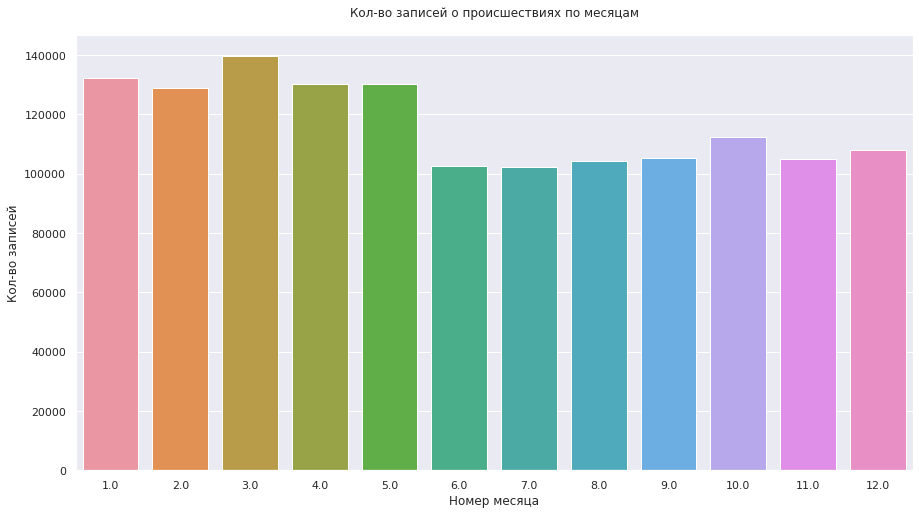

In [50]:
plt.figure(figsize=(15,8))

g = sns.barplot(data=df,x='month',y='count')

g.set_title('Кол-во записей о происшествиях по месяцам',y=1.03)

g.set(xlabel='Номер месяца',
     ylabel='Кол-во записей')

plt.show()

В первые 5 месяцев кол-во происшествий значительно выше, чем в остальные.

**Исследование зависимости серьезности повреждений транспортного средства и состояния дороги**

In [51]:
query = '''
SELECT p.case_id,
        p.party_type,
        c.collision_damage,
        c.road_condition_1
FROM parties as p
JOIN collisions as c ON p.case_id = c.case_id
WHERE p.party_type = 'car'

'''

df = pd.read_sql_query(query,con=engine)
df

,case_id,party_type,collision_damage,road_condition_1
0,4021529,car,small damage,normal
1,4021668,car,small damage,normal
2,4035225,car,small damage,normal
3,4035651,car,small damage,normal
4,4036224,car,scratch,normal
...,...,...,...,...
2469309,5456544,car,small damage,normal
2469310,5456579,car,severe damage,normal
2469311,5456610,car,small damage,normal
2469312,5456619,car,middle damage,normal


In [52]:
df['road_condition_1'].value_counts()

normal            2377455
construction        38331
holes                9222
other                8397
obstruction          8284
loose material       3657
reduced width        2329
flooded              1577
Name: road_condition_1, dtype: int64

Обычных дорог более чем в 100 раз больше чем остальных.

Описание состояния дороги:  
A — Holes, Deep Ruts (Ямы, глубокая колея),  
B — Loose Material on Roadway (Сыпучий материал на проезжей части),  
C — Obstruction on Roadway (Препятствие на проезжей части),  
D — Construction or Repair Zone (Зона строительства или ремонта),  
E — Reduced Roadway Width (Уменьшенная ширина проезжей части),  
F — Flooded (Затоплено),G — Other (Другое),  
H — No Unusual Condition (Нет ничего необычного),  
\- — Not Stated (Не указано)  

,construction,flooded,holes,loose material,normal,obstruction,other,reduced width
small damage,0.630,0.594,0.579,0.587,0.595,0.662,0.608,0.717
scratch,0.255,0.264,0.283,0.195,0.275,0.214,0.241,0.183
middle damage,0.089,0.120,0.115,0.164,0.105,0.094,0.116,0.082
severe damage,0.017,0.017,0.020,0.042,0.018,0.022,0.026,0.013
fatal,0.009,0.004,0.003,0.012,0.006,0.009,0.009,0.005


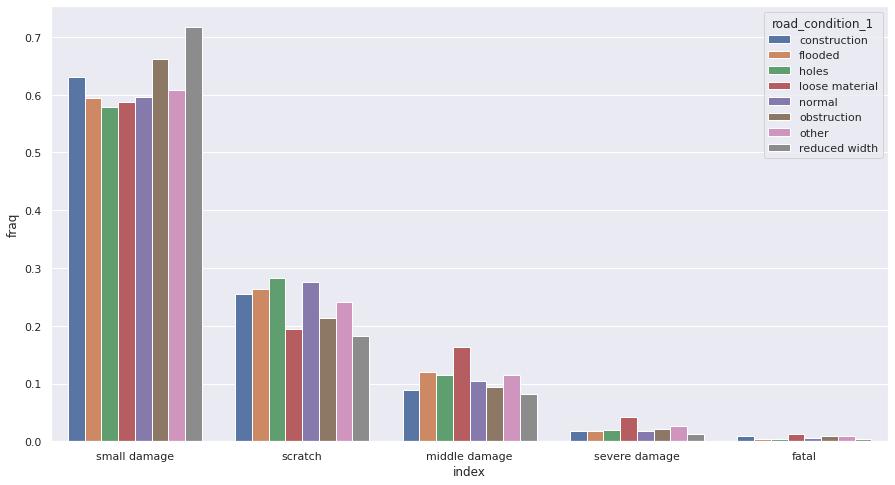

In [53]:
temp1 = pd.DataFrame()
for name,data in df.groupby('road_condition_1'):
    vc = data['collision_damage'].value_counts(normalize=True)
    # g = sns.barplot(x=vc.index,y=vc)
    # g.set_xticklabels(g.get_xticklabels(),rotation=30)
    # plt.show()
    vc.name = name
    temp1 = pd.concat([temp1,vc],axis=1)
display(temp1)
temp2 = pd.melt(temp1,ignore_index=False,var_name='road_condition_1',value_name='fraq').reset_index()

plt.figure(figsize=(15,8))
sns.barplot(data=temp2,x='index',y='fraq',hue='road_condition_1')
plt.show()

Здесь мы видим основное распределение с делением по типам состояния дороги.

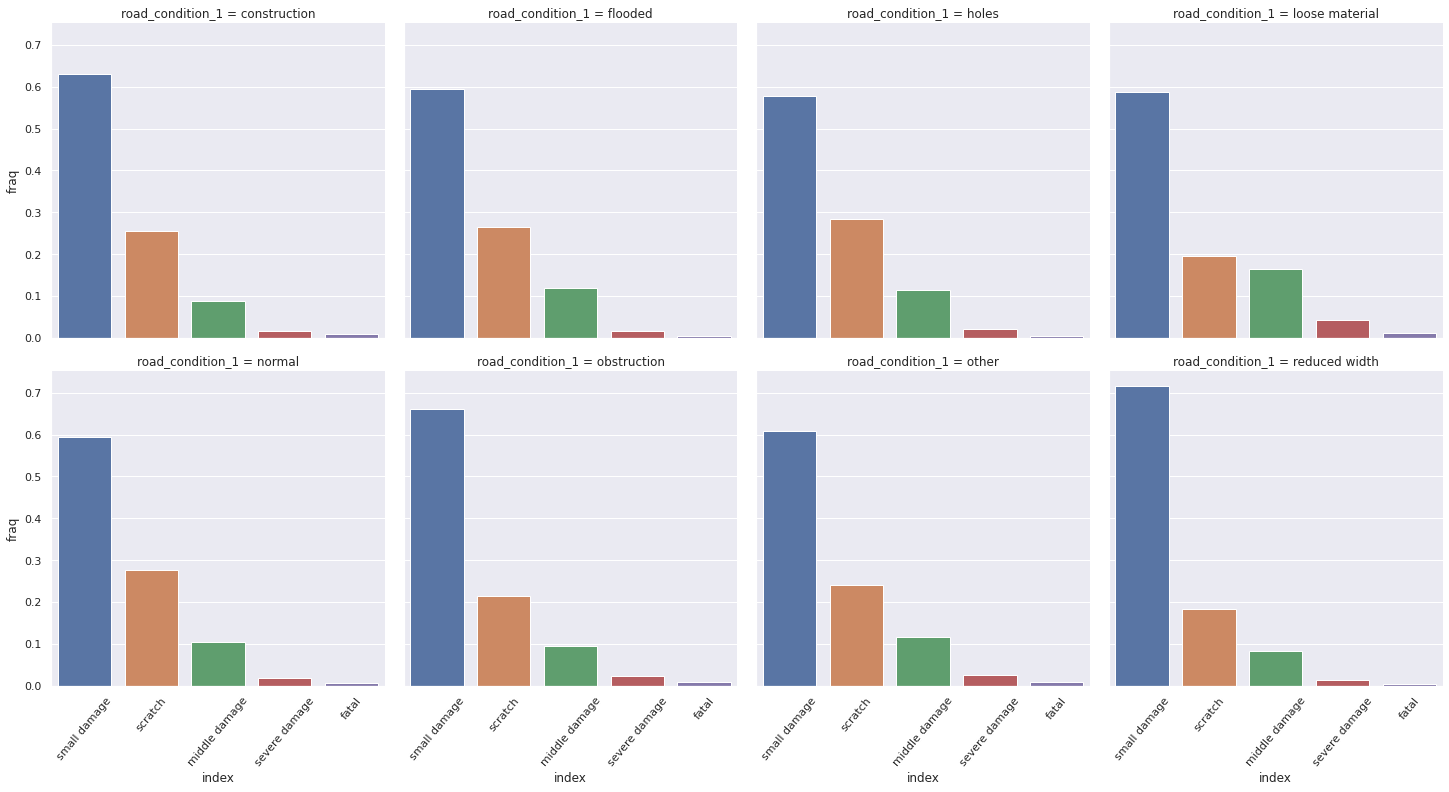

In [54]:
g = sns.catplot(data=temp2,x='index',y='fraq',col='road_condition_1',kind='bar',col_wrap=4)
g.set_xticklabels(rotation=50)
plt.show()

Это распределения по каждому типу состояния дороги отдельным графиком.

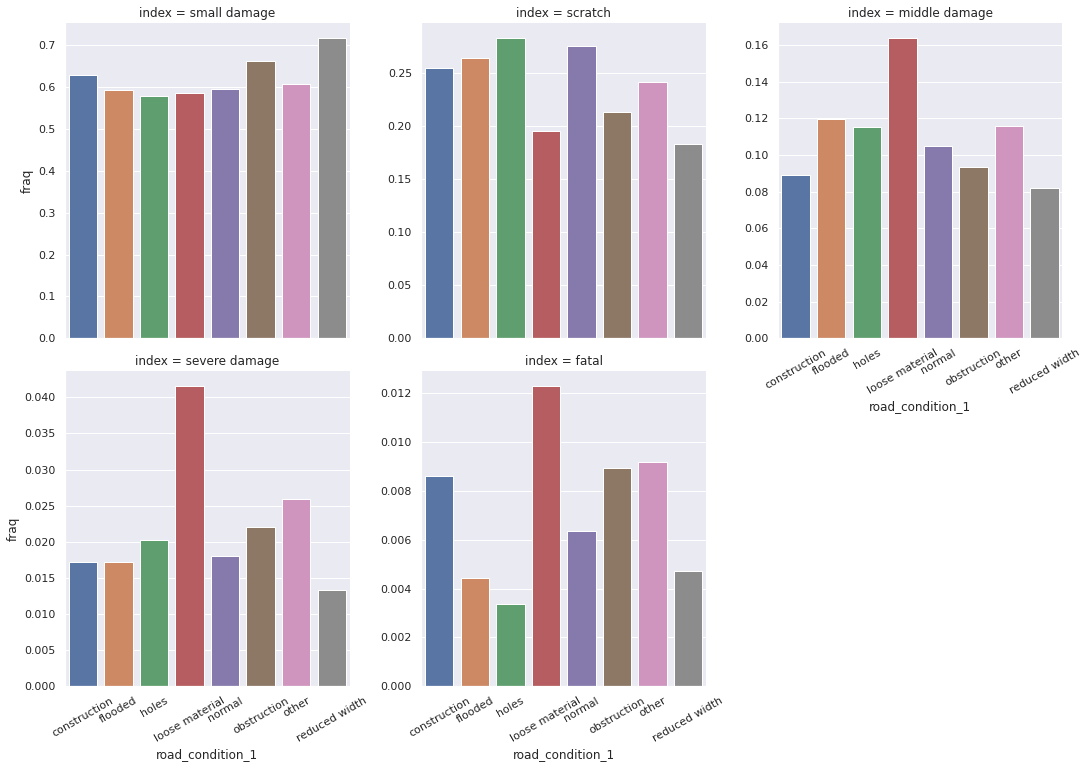

In [55]:
g = sns.catplot(data=temp2,x='road_condition_1',y='fraq',col='index',kind='bar',col_wrap=3,sharey=False,sharex=True)
g.set_xticklabels(rotation=30)
plt.show()

Здесь мы можем сравнить "вероятность" типов повреждений (каждый график) по отношению к каждому типу состояния дороги (столбцы).


* `small damage` - (от большей к меньшей) `reduced width`, `obstruction`, `construction`
* `scratch` - `holes`, `normal`, `flooded` и меньше всего на `reduced width`
* `middle damage` - `loose material` (обгоняет другие)
* `severe damage` - `loose material` (обгоняет другие), на втором месте категория `other`
* `fatal` - `loose material`,`other`,`obstruction`,`construction`


In [56]:
# g = sns.catplot(data=df,x='collision_damage',kind='count',col='road_condition_1',col_wrap=4,sharey=False)
# g.set_xticklabels(rotation=50)
# g.fig.suptitle('Сравнение серьезности повреждений по отношению к состоянию дороги',y=1.03)
# plt.show()

# g = sns.catplot(data=df,x='road_condition_1',kind='count',col='collision_damage',col_wrap=3,sharey=False)
# g.set_xticklabels(rotation=50)
# g.fig.suptitle('Сравнение серьезности повреждений по отношению к состоянию дороги',y=1.03)
# plt.show()


**Исследования причин ДТП**

`'party_sobriety'`:  
A — Had Not Been Drinking (Не пил),  
B — Had Been Drinking, Under Influence (Был пьян, под влиянием),  
C — Had Been Drinking, Not Under Influence (Был пьян, не под влиянием),  
D — Had Been Drinking, Impairment Unknown (Был пьян, ухудшение неизвестно),  
G — Impairment Unknown (Неизвестно ухудшение),  
H — Not Applicable (Не оценивался),  
\- — Not Stated (Не указано)  

`'party_drug_physical'`:  
E — Under Drug Influence (Под воздействием лекарств),  
F — Impairment — Physical (Ухудшение состояния),  
G — Impairment Unknown (Не известно),  
H — Not Applicable (Не оценивался),  
I — Sleepy/Fatigued (Сонный/Усталый),  
\- — Not Stated (Не указано)  

In [57]:
query = '''
SELECT at_fault,party_sobriety,party_drug_physical,cellphone_in_use
FROM parties
WHERE party_type = 'car'

'''

df = pd.read_sql_query(query,con=engine)
df

,at_fault,party_sobriety,party_drug_physical,cellphone_in_use
0,0,had not been drinking,None,0.000
1,0,had not been drinking,None,0.000
2,0,had not been drinking,None,1.000
3,0,impairment unknown,G,0.000
4,1,had not been drinking,None,0.000
...,...,...,...,...
2469309,0,not applicable,not applicable,0.000
2469310,0,had not been drinking,None,NaN
2469311,1,had not been drinking,None,1.000
2469312,0,had not been drinking,None,1.000


In [58]:
for col in ['party_sobriety', 'party_drug_physical', 'cellphone_in_use']:
    display(df[col].value_counts())
    print()

had not been drinking                     2032489
impairment unknown                         225085
had been drinking, under influence         108524
not applicable                              24024
had been drinking, impairment unknown       18753
had been drinking, not under influence      16232
Name: party_sobriety, dtype: int64

G                        225085
not applicable            24024
sleepy/fatigued           12542
under drug influence      12361
impairment - physical      4059
Name: party_drug_physical, dtype: int64

0.000    2050923
1.000      43641
Name: cellphone_in_use, dtype: int64

In [59]:
def get_fraqs_by_at_fault(col):
    temp1 = pd.DataFrame()
    for name,data in df.groupby('at_fault'):
        # print('at_fault =',name)
        data.loc[data['party_sobriety'] == 'not applicable','party_sobriety'] = 'sobriety not applicable'

        # vc = data[col].value_counts()
        vc_norm = data[col].value_counts(normalize=True)
        # vc.name = str(name) + '_support'
        vc_norm.name = str(name) + '_fraq'
        temp1 = pd.concat([temp1,
                           # vc,
                           vc_norm],axis=1)

    display(temp1)
    return pd.melt(temp1,ignore_index=False).reset_index()
    


In [60]:
def plot_bars(df,title):
    plt.figure(figsize=(15,8))
    g = sns.barplot(data=df,x='index',y='value',hue='variable')
    plt.xticks(rotation=30)
    plt.show()

    g = sns.catplot(kind='bar',data=df,x='index',y='value',col='variable',aspect=1.2,height=7)

    g.set_xticklabels(rotation=30)
    g.fig.suptitle(title,y=1.03)
    plt.show()

    g = sns.catplot(kind='bar',data=df,x='variable',y='value',col='index',aspect=1.5,height=3,col_wrap=3,sharey=False)

    g.set_xticklabels(rotation=30)
    g.fig.suptitle(title,y=1.03)
    plt.show()



In [61]:
lst_ = ['party_sobriety', 'party_drug_physical', 'cellphone_in_use']

,0_fraq,1_fraq
had not been drinking,0.940,0.737
impairment unknown,0.038,0.147
sobriety not applicable,0.011,0.009
"had been drinking, under influence",0.004,0.085
"had been drinking, not under influence",0.004,0.009
"had been drinking, impairment unknown",0.003,0.013


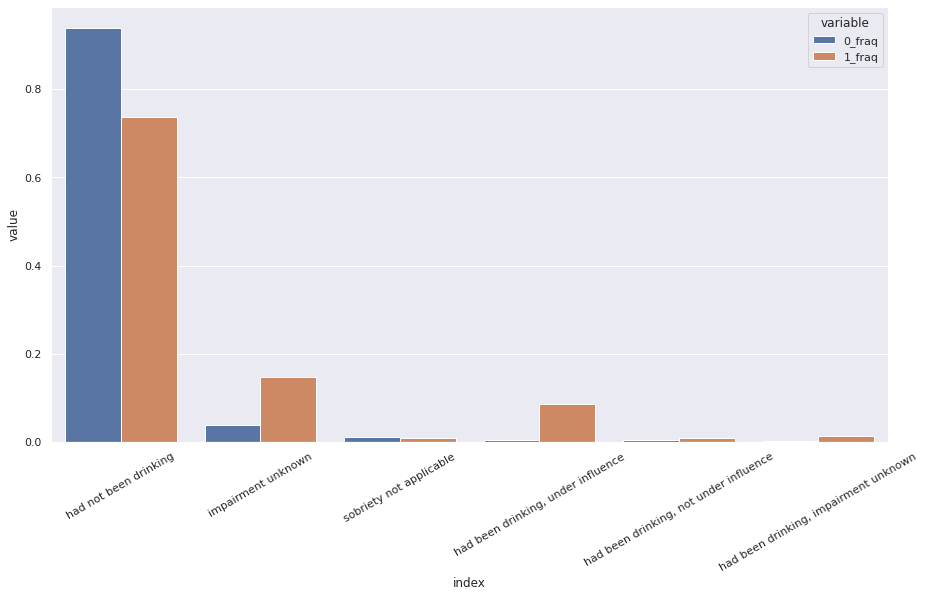

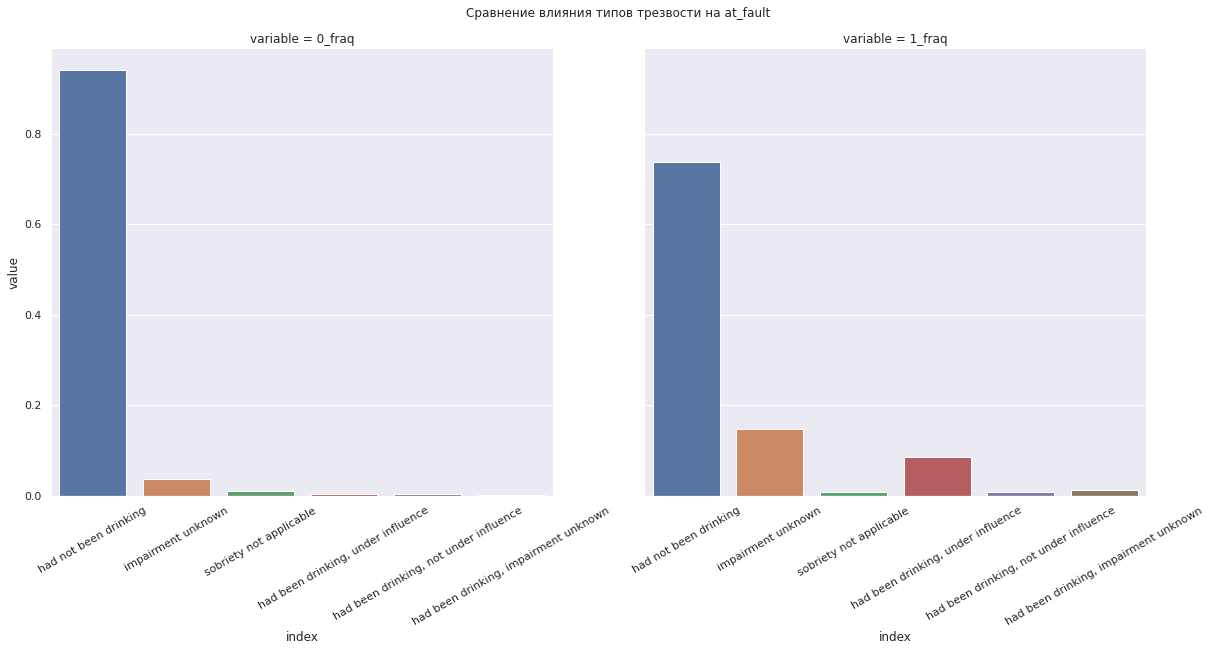

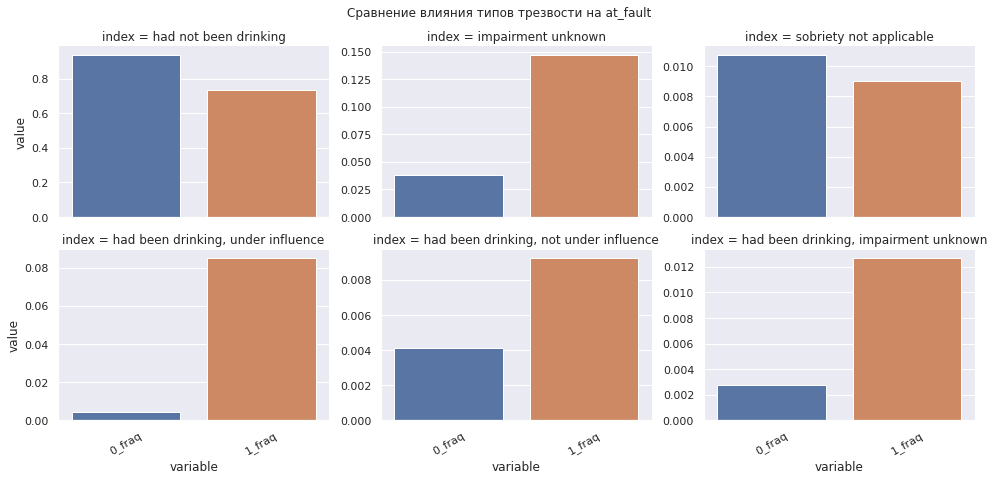

In [62]:
sobriety = get_fraqs_by_at_fault('party_sobriety')
plot_bars(sobriety,'Сравнение влияния типов трезвости на at_fault')

Опьянение определенно влияет вероятность стать виновником аварии.

,0_fraq,1_fraq
G,0.736,0.831
not applicable,0.207,0.051
impairment - physical,0.035,0.008
under drug influence,0.013,0.054
sleepy/fatigued,0.008,0.056


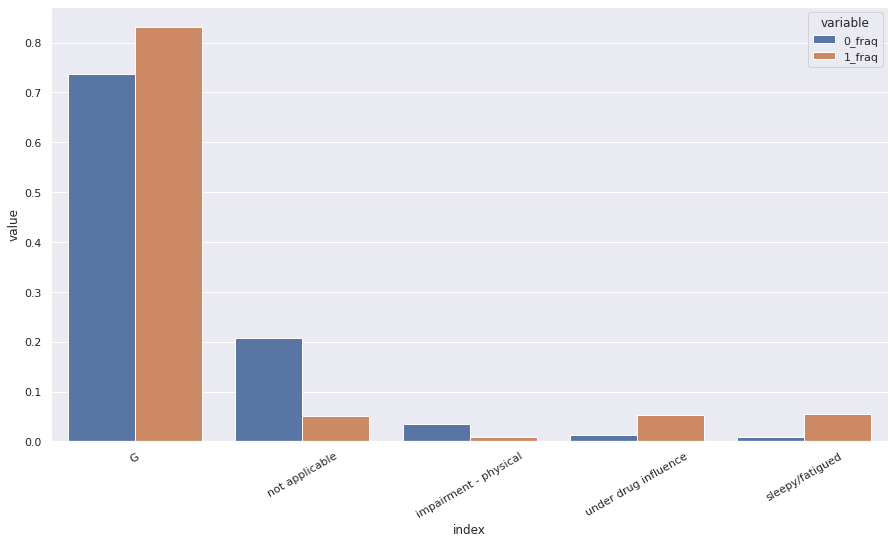

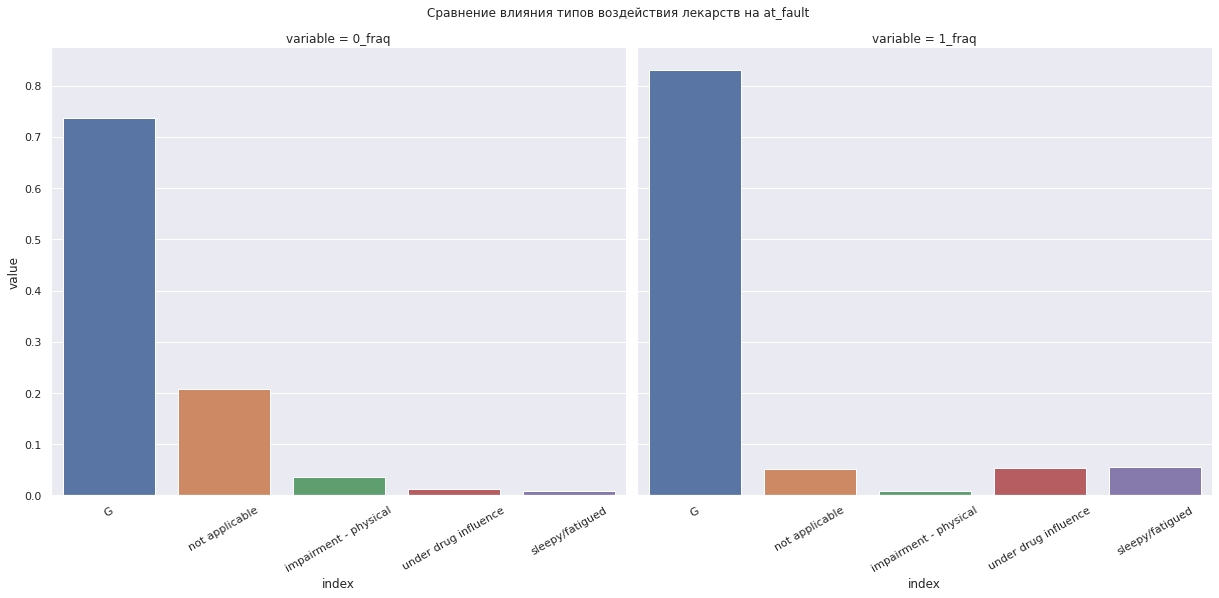

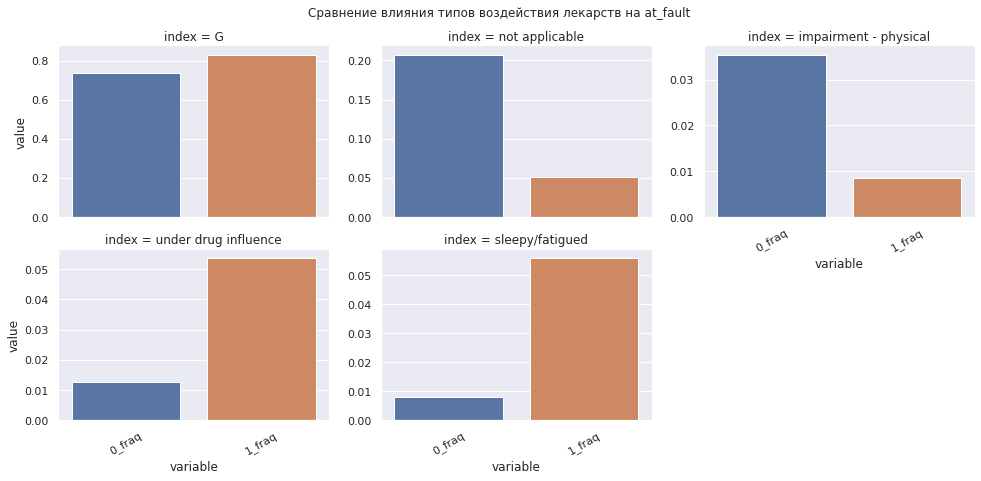

In [63]:
drug = get_fraqs_by_at_fault('party_drug_physical')
plot_bars(drug,'Сравнение влияния типов воздействия лекарств на at_fault')

Напомним, что G - Impairment Unknown (Не известно). Истощение и воздействие лекарств повышает вероятность стать виновником аварии.

,0_fraq,1_fraq
0.000,0.982,0.977
1.000,0.018,0.023


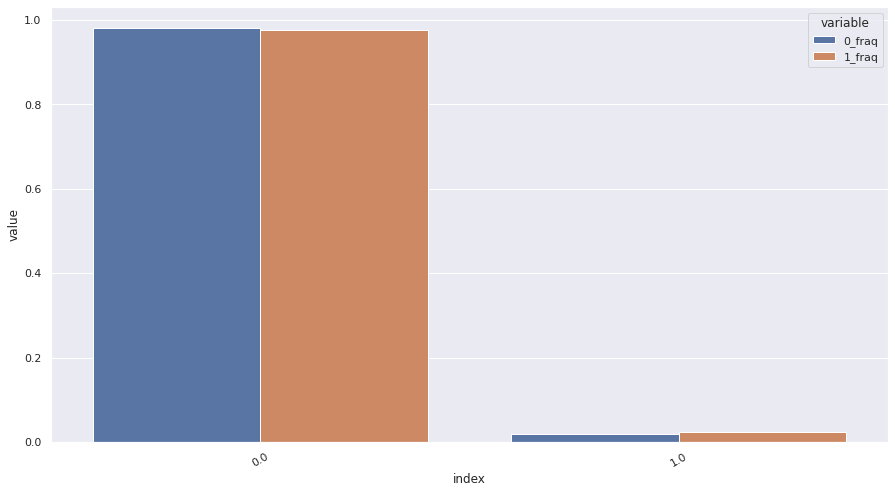

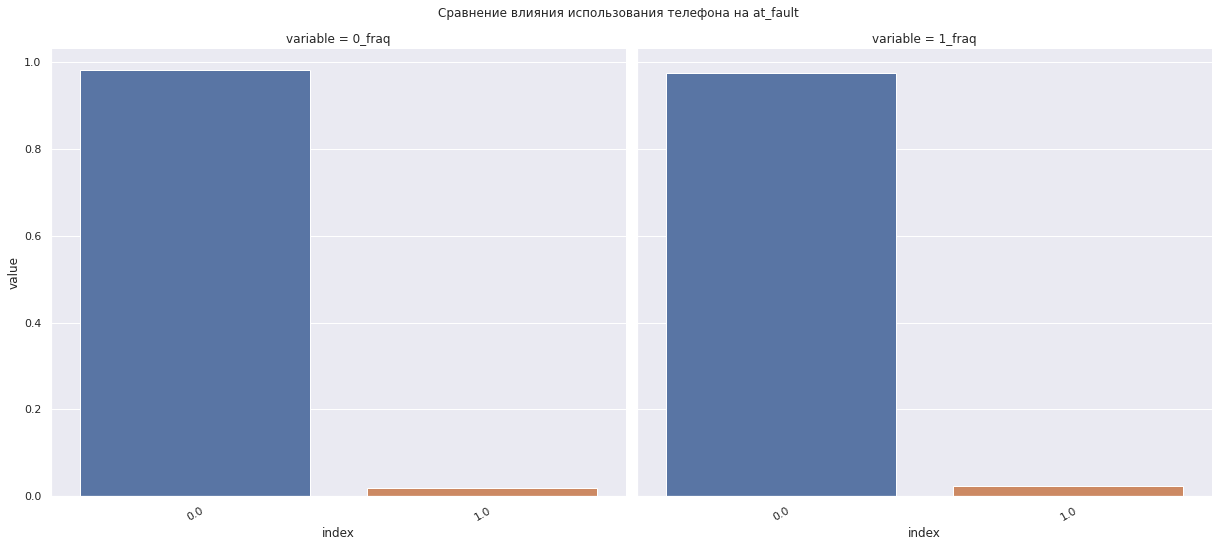

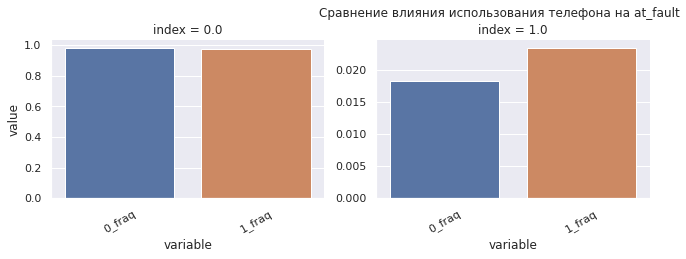

In [64]:
cellphone = get_fraqs_by_at_fault('cellphone_in_use')
plot_bars(cellphone,'Сравнение влияния использования телефона на at_fault')

Использование телефона немного повышает на вероятность стать виновником аварии. (Или это наличие возвожности громкой связи в автомобиле?)

Какие еще исследования стоит провести?  
В первую очередь нужно смотреть то, на что можно повлиять. Это все, что относится к машине и к водителю.

1. зависимость величины страховки автомобиля от вероятность стать виновником аварии
2. Тип КПП от at_fault
3. vehicle_age от at_fault
4. control condition от at_fault
5. control_condition + vehicle age от at_fault
6. Зависимость локации от at_fault
7. type_of_collision от тяжести урона


Возьмем 6 и 7 пункты.

**Исследование зависимости локации от at_fault**

In [65]:
query = '''
SELECT --p.case_id,
       p.party_type,
       p.at_fault,
       c.county_location
FROM parties as p
JOIN collisions as c ON p.case_id = c.case_id
'''

df = pd.read_sql_query(query,con=engine)
df

,party_type,at_fault,county_location
0,building,1,los angeles
1,road bumper,0,marin
2,road signs,1,san bernardino
3,building,1,orange
4,road bumper,0,san mateo
...,...,...,...
2752403,car,1,contra costa
2752404,car,1,san diego
2752405,car,1,kings
2752406,car,1,san diego


Где чаще виноват автомобиль?

In [66]:
temp1 = pd.DataFrame()
for name,data in df.groupby('party_type'):
    # print(name)
    for col,data2 in data.groupby('county_location'):
        # print(col)
        # display(df)
        vc_norm = data2['at_fault'].value_counts(normalize=True).sort_index()
        # display(vc_norm)
        temp2 = pd.DataFrame([name,col,*vc_norm.values])
        temp1 = pd.concat([temp1,temp2.T])

temp1 = temp1.fillna(0).reset_index(drop=True)
temp1.columns = ['party_type','county_location','at_fault_0','at_fault_1']
temp1

,party_type,county_location,at_fault_0,at_fault_1
0,building,alameda,0.515,0.485
1,building,alpine,0.714,0.286
2,building,amador,0.435,0.565
3,building,butte,0.412,0.588
4,building,calaveras,0.154,0.846
...,...,...,...,...
284,road signs,tulare,0.596,0.404
285,road signs,tuolumne,0.686,0.314
286,road signs,ventura,0.677,0.323
287,road signs,yolo,0.669,0.331


In [67]:
temp1.isna().sum()

party_type         0
county_location    0
at_fault_0         0
at_fault_1         0
dtype: int64

Посторим график с соотношением виновных в аварии по типу "виновника" (`party_type`, график) и локации (`county_location`, столбцы).

/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:3803: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


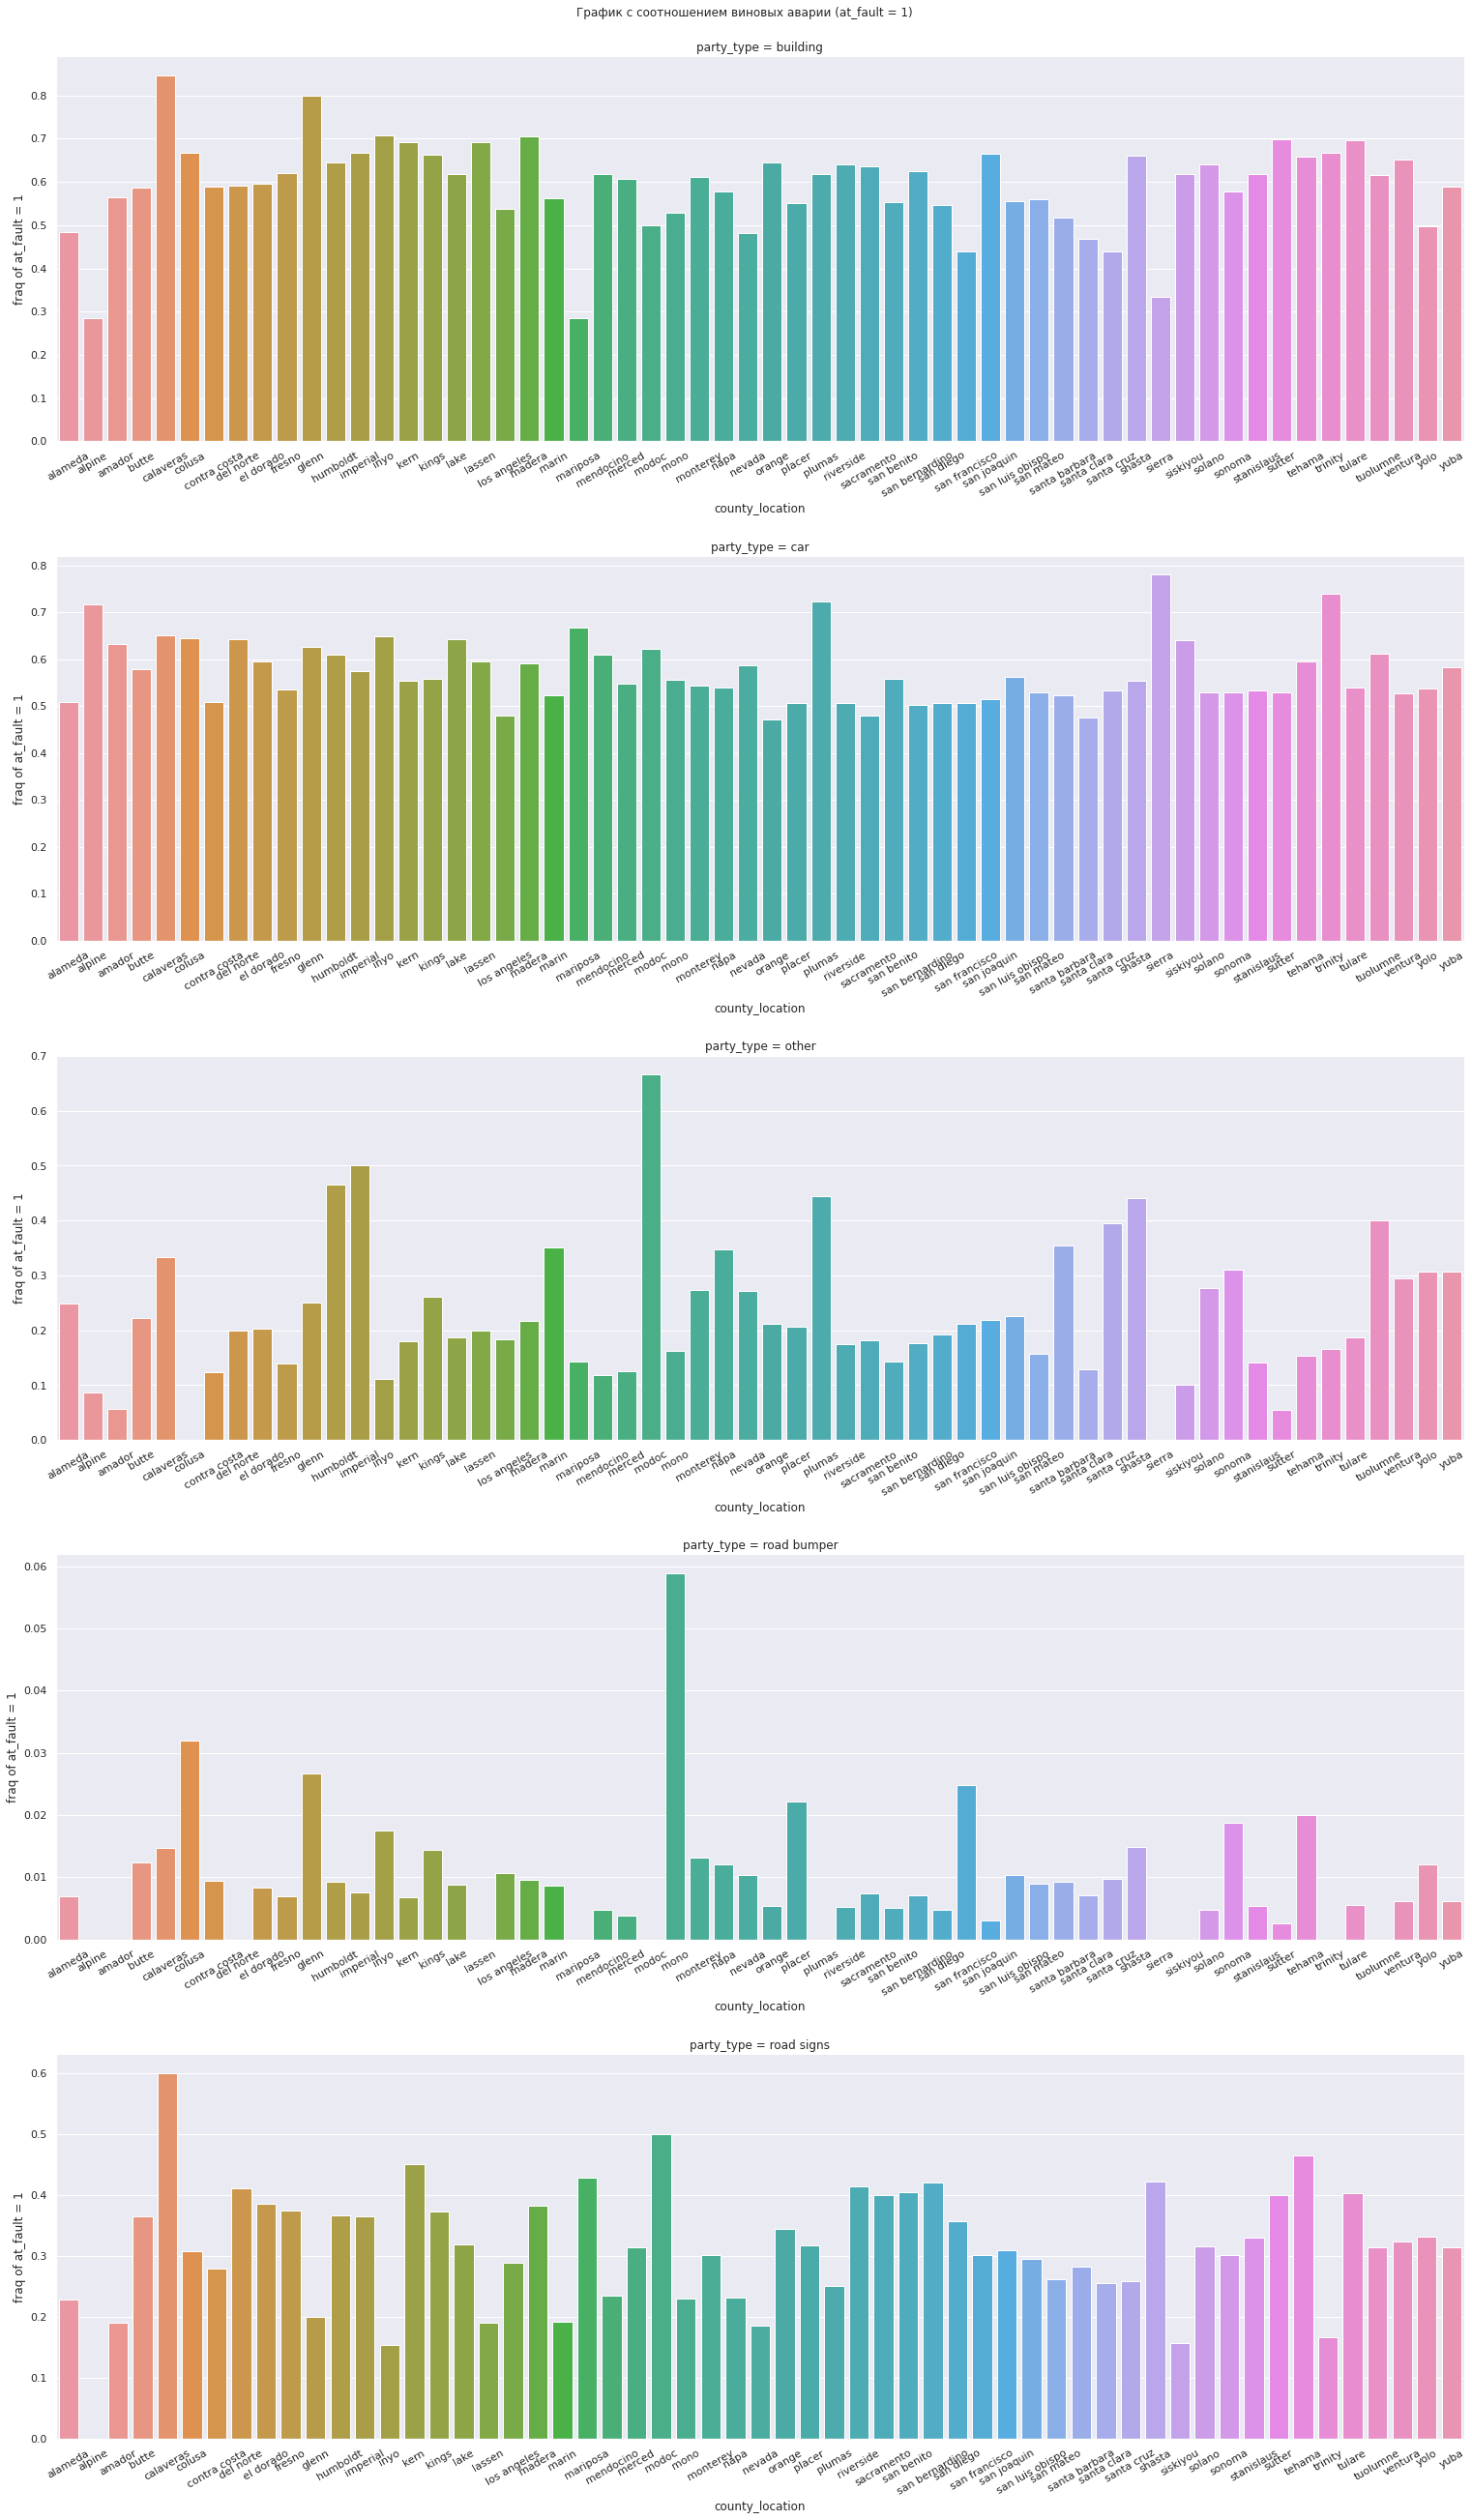

In [68]:
g = sns.catplot(data=temp1,x='county_location',y='at_fault_1',col='party_type',kind='bar',aspect=3,height=7,col_wrap=1,sharex=False,sharey=False)
g.fig.suptitle('График с соотношением виновых аварии (at_fault = 1)',y=1.01)
g.set_xticklabels(rotation=30)
g.set(ylabel='fraq of at_fault = 1',
      xlabel='county_location')
plt.subplots_adjust(hspace=0.3)
plt.show()

* `buildings` - `calaveras`, `glenn` ~ 0.8
* `car` - `plumas`, `apline` ~ 0.7
* `other` - `modoc`, `imperial`,`humboldt`,`plumas`
* `road bumper` - (very low, all less then 0.06)`mono`
* `road signs` - `calaveras` (0.6), `modoc` (0.5)

Построим такой же график, но для `at_fault=0`.

/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:3803: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


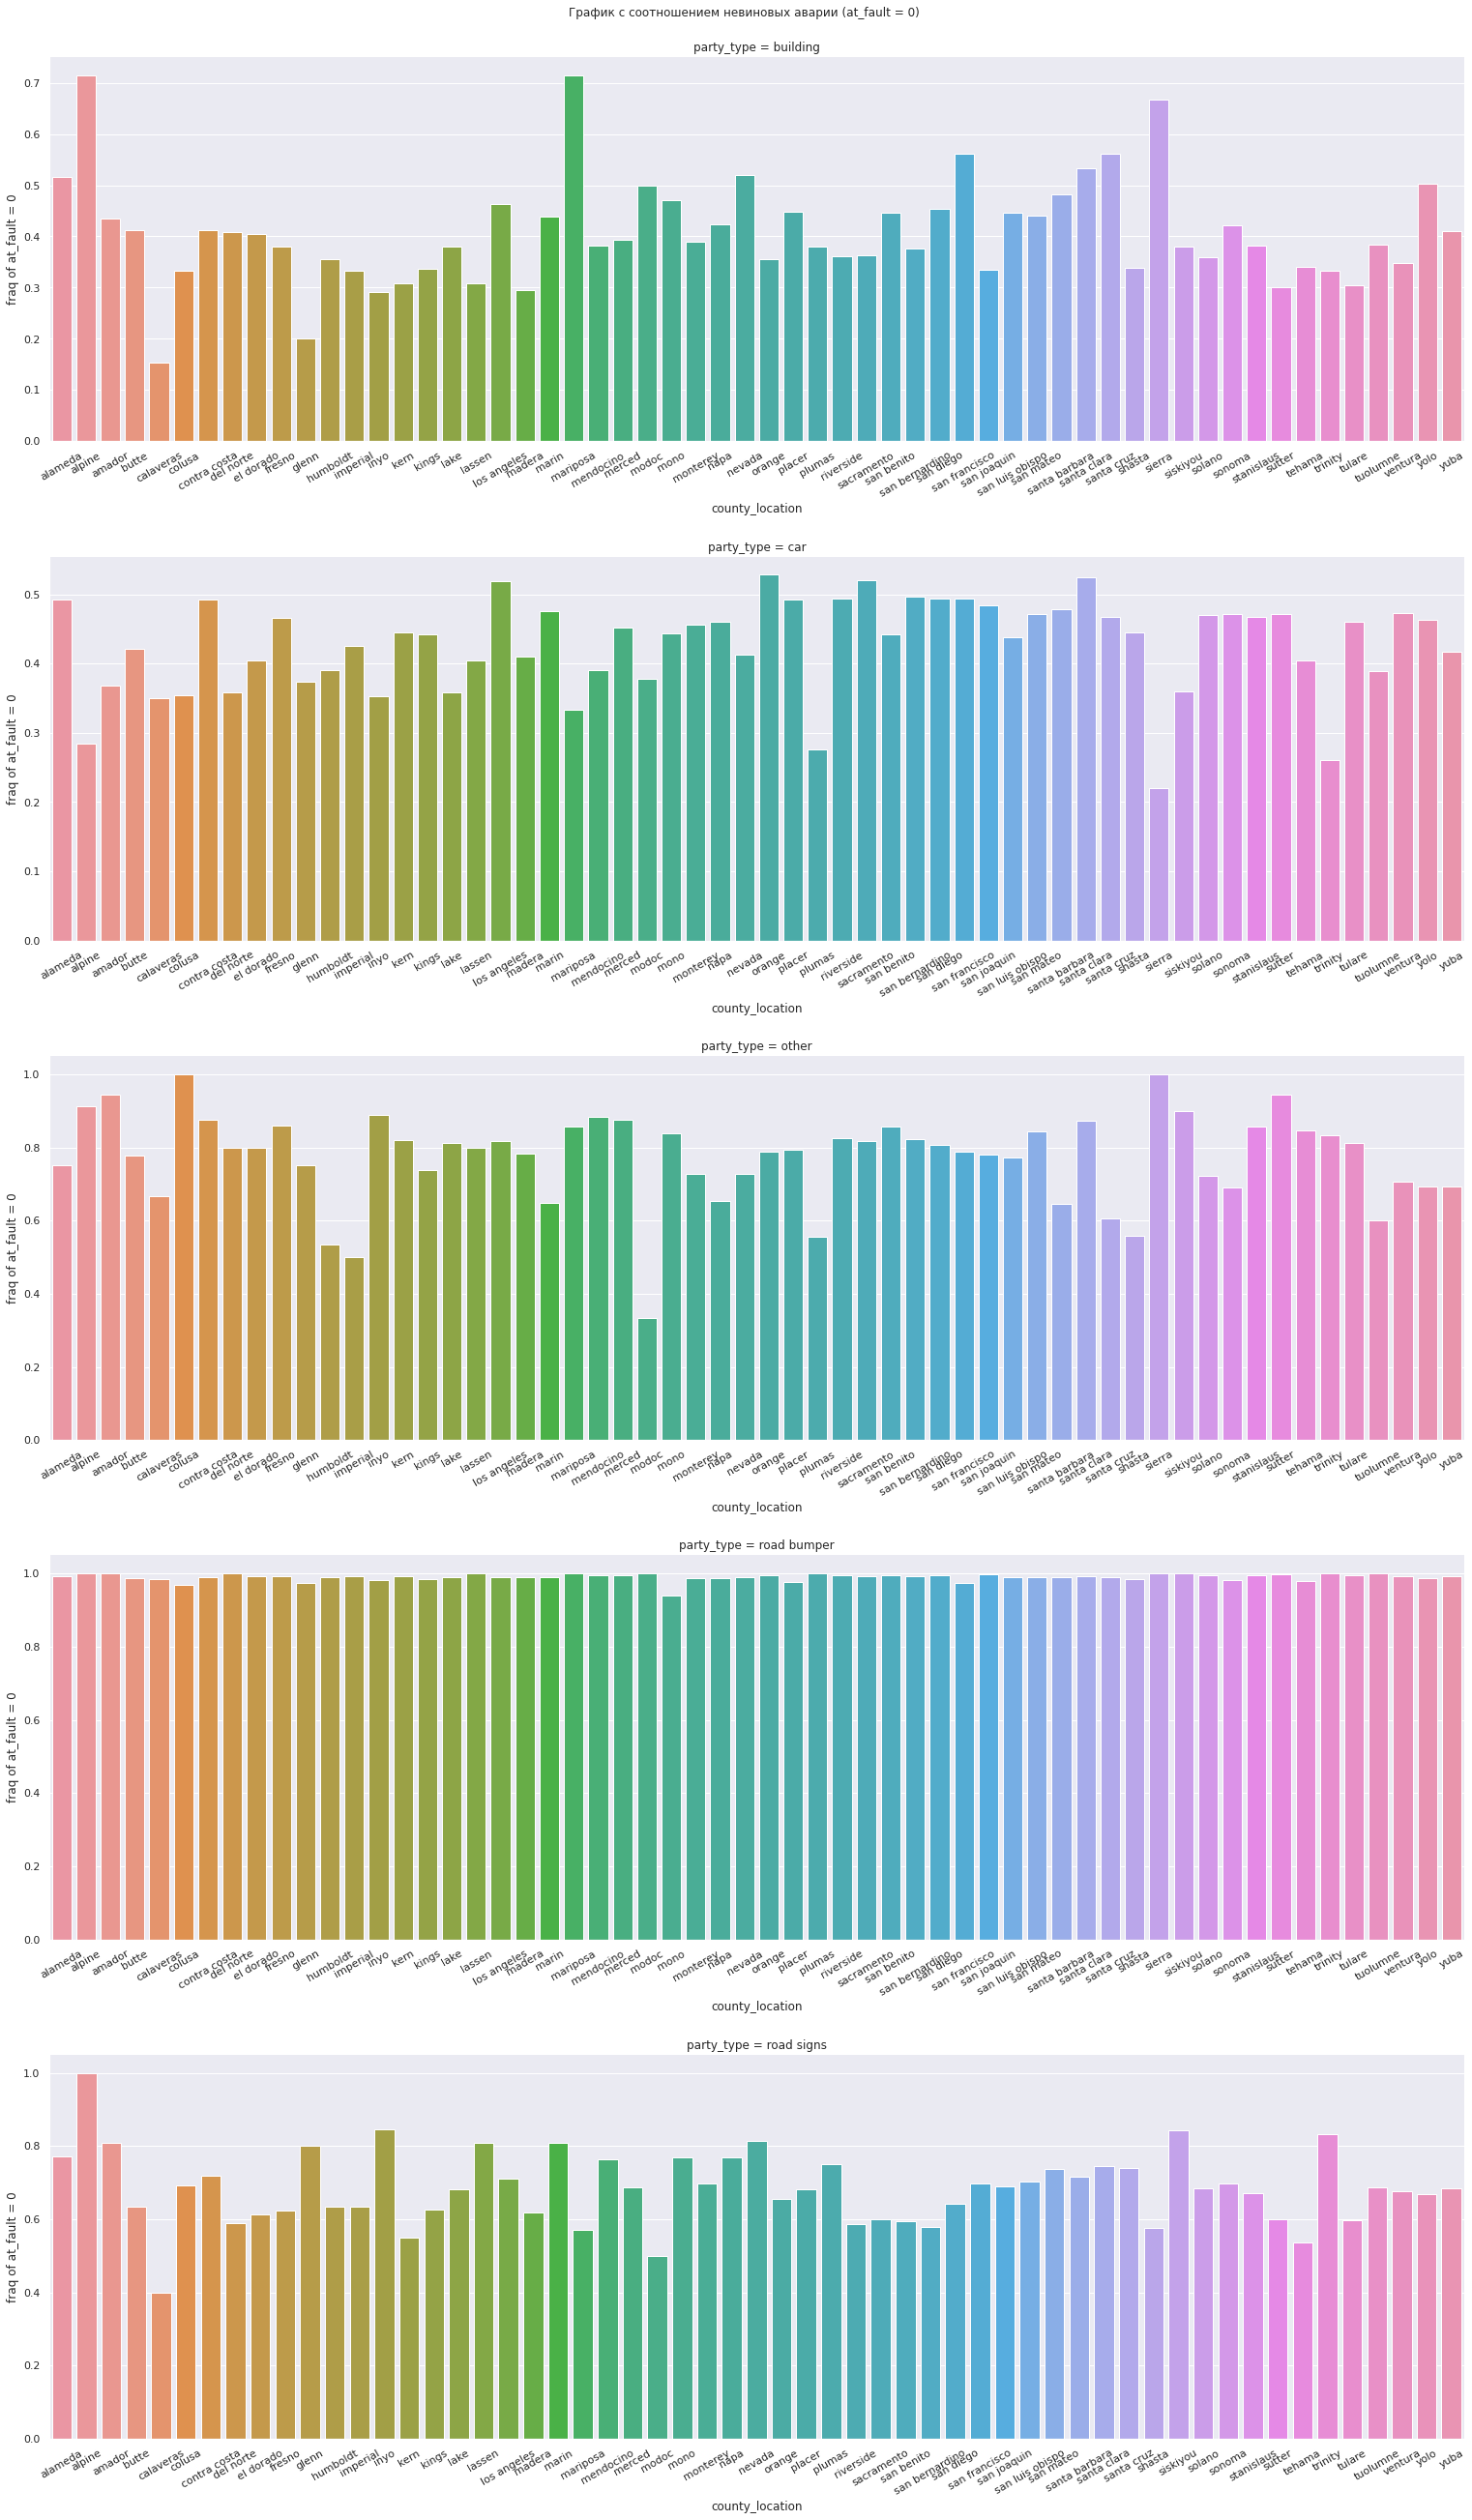

In [69]:
g = sns.catplot(data=temp1,x='county_location',y='at_fault_0',col='party_type',kind='bar',aspect=3,height=7,col_wrap=1,sharex=False,sharey=False)
g.fig.suptitle('График с соотношением невиновых аварии (at_fault = 0)',y=1.01)
g.set_xticklabels(rotation=30)
g.set(ylabel='fraq of at_fault = 0',
      xlabel='county_location')
plt.subplots_adjust(hspace=0.3)
plt.show()

Доля *невиновных* в аварии (`at_fault=0`)
* `buildings` - `apline`, `maripossa` ~ 0.7
* `car` - все довольно равномерно ~0.5
* `other` - `colussa`,`sierra` = 1.0, многие другие близки к 0.9,0.8
* `road bumper` - все близки к 1
* `road signs` - `alpine` (1), остальные не выше 0.8

**Исследование типа столкновения от тяжести урона виновного автомобиля**

In [70]:
query = '''
SELECT c.collision_damage,
       c.primary_collision_factor
FROM parties as p
JOIN collisions as c ON c.case_id = p.case_id
WHERE p.at_fault = 1
'''

df = pd.read_sql_query(query,con=engine)
df

,collision_damage,primary_collision_factor
0,scratch,vehicle code violation
1,fatal,vehicle code violation
2,middle damage,vehicle code violation
3,small damage,vehicle code violation
4,scratch,vehicle code violation
...,...,...
1288122,scratch,vehicle code violation
1288123,small damage,vehicle code violation
1288124,severe damage,vehicle code violation
1288125,small damage,vehicle code violation


Column name: fatal


vehicle code violation   0.998
other improper driving   0.002
Name: primary_collision_factor, dtype: float64

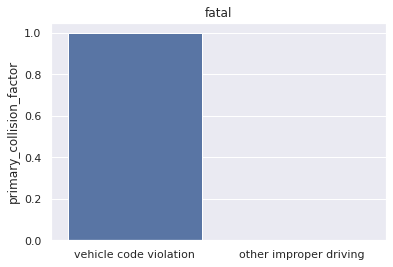

--------------------
Column name: middle damage


vehicle code violation   0.995
other improper driving   0.005
fell asleep              0.000
Name: primary_collision_factor, dtype: float64

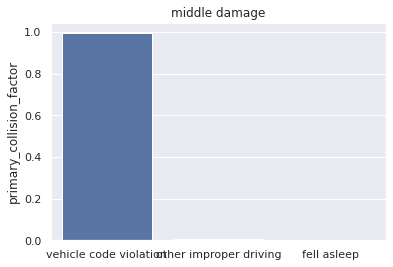

--------------------
Column name: scratch


vehicle code violation   0.996
other improper driving   0.004
fell asleep              0.000
Name: primary_collision_factor, dtype: float64

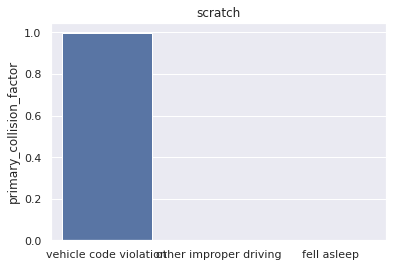

--------------------
Column name: severe damage


vehicle code violation   0.995
other improper driving   0.005
fell asleep              0.000
Name: primary_collision_factor, dtype: float64

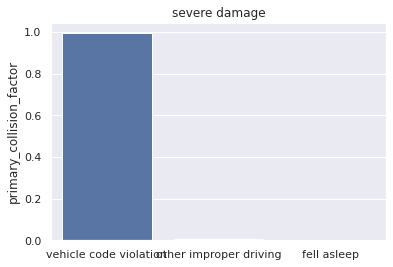

--------------------
Column name: small damage


vehicle code violation   0.994
other improper driving   0.006
fell asleep              0.000
Name: primary_collision_factor, dtype: float64

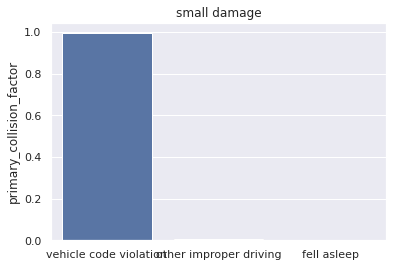

--------------------


In [71]:
for name,data in df.groupby('collision_damage'):
    print('Column name:',name)
    vc = data['primary_collision_factor'].value_counts(normalize=True)
    display(vc)
    g = sns.barplot(x=vc.index,y=vc)
    g.set_title(name)
    plt.show()
    print('-'*20)


Основная причина: нарушение правил. Во всех типах без изменения.

## Подготовка данных для модели

* Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties)
* Для модели выбрать тип виновника — только машина (car).
* Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
* Для моделирования ограничиться данными за 2012 год — они самые свежие.
* Обязательное условие — учесть фактор возраста автомобиля.

In [72]:
query = '''
WITH cars AS (SELECT *
                        FROM parties
                        WHERE party_type = 'car' 
                        --AND at_fault = 1
                        ),
                        
    vehicle_info AS (SELECT c.case_id as cars_case_id,
                        c.party_number,
                        c.party_type,
                        c.at_fault,
                        c.insurance_premium,
                        c.party_sobriety,
                        c.party_drug_physical,
                        c.cellphone_in_use,
                        v.vehicle_type,
                        v.vehicle_transmission,
                        v.vehicle_age
                  FROM cars as c
                  JOIN vehicles as v ON c.case_id = v.case_id
                                      AND c.party_number = v.party_number
                ),

     damage AS (SELECT *
                FROM collisions
                WHERE collision_damage != 'scratch'
                AND DATE_TRUNC('year',CAST(collision_date AS date)) = '2012-01-01'
)


SELECT *
FROM damage as d
JOIN vehicle_info as v ON d.case_id = v.cars_case_id
ORDER BY d.case_id
'''

df = pd.read_sql_query(query,con=engine,parse_dates='collision_date')
df

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,...,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age
0,5125160,3712,san diego,0.000,None,1.000,cloudy,None,small damage,2,...,2,car,0,42.000,had not been drinking,None,0.000,sedan,auto,2.000
1,5173738,3404,sacramento,0.000,None,1.000,clear,None,small damage,2,...,2,car,0,31.000,had not been drinking,None,0.000,sedan,auto,5.000
2,5269486,3400,sacramento,0.000,None,1.000,clear,None,small damage,2,...,2,car,0,21.000,had not been drinking,None,0.000,sedan,auto,1.000
3,5319820,3607,san bernardino,5.000,east,0.000,clear,None,small damage,2,...,2,car,0,31.000,had not been drinking,None,0.000,sedan,auto,4.000
4,5329109,3400,sacramento,0.000,None,1.000,clear,None,middle damage,2,...,1,car,0,41.000,had not been drinking,None,0.000,coupe,auto,6.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56243,5668337,1942,los angeles,350.000,east,0.000,clear,highway,small damage,3,...,3,car,0,51.000,had not been drinking,None,0.000,sedan,manual,6.000
56244,5668348,0109,alameda,0.000,None,1.000,clear,None,small damage,2,...,2,car,0,24.000,had not been drinking,None,NaN,sedan,manual,3.000
56245,5668349,1942,los angeles,25.000,north,0.000,clear,highway,small damage,2,...,2,car,1,79.000,had not been drinking,None,0.000,sedan,manual,12.000
56246,5668352,0109,alameda,0.000,None,1.000,clear,ramp,small damage,2,...,2,car,0,21.000,had not been drinking,None,0.000,sedan,auto,3.000


In [73]:
df.duplicated().sum()

0

Сначала убираем точно бесполезные фичи.

In [74]:
df.columns

Index(['case_id', 'county_city_location', 'county_location', 'distance',
       'direction', 'intersection', 'weather_1', 'location_type',
       'collision_damage', 'party_count', 'primary_collision_factor',
       'pcf_violation_category', 'type_of_collision',
       'motor_vehicle_involved_with', 'road_surface', 'road_condition_1',
       'lighting', 'control_device', 'collision_date', 'collision_time',
       'cars_case_id', 'party_number', 'party_type', 'at_fault',
       'insurance_premium', 'party_sobriety', 'party_drug_physical',
       'cellphone_in_use', 'vehicle_type', 'vehicle_transmission',
       'vehicle_age'],
      dtype='object')

In [75]:
cols_to_drop = [
                'case_id', 
                'distance', # дистанция может быть известна только после аварии
                'direction', # same
                'intersection', # same
                'location_type',
                'collision_damage', 
                # 'party_count',
                'primary_collision_factor',
                'pcf_violation_category',
                'type_of_collision',
                'motor_vehicle_involved_with',
                'road_surface', # зависит от погоды, может отличаться 
                'road_condition_1', # может отличаться в регионе
                'lighting', # может отличаться, + зависит от погоды, времени и сезона
                'collision_time', # известно на момент аварии
                # 'party_number', # известно на момент аварии
                'party_type'] # в этих данных только car
               

Основная проблема с построением модели на этих данных в том, что нельзя описать маршрут, например, одним значением `distance`. Этот признак может меняться на протяжении всего маршрута. И это относится ко многим предоставленным признакам: `direction`, `intersection`, `location_type` и т.д.

Значит маршрут должен подаваться поделенный на отрезки, чтобы можно было оценить вероятность аварии на каждом отрезке и из этого делать предсказание.

Но по имеющимся данным, попробуем предсказать вероятность аварии по информации известной на момент, когда водитель сел за руль.

In [76]:
df = df.drop(columns=cols_to_drop)

In [77]:
df.columns

Index(['county_city_location', 'county_location', 'weather_1', 'party_count',
       'control_device', 'collision_date', 'cars_case_id', 'party_number',
       'at_fault', 'insurance_premium', 'party_sobriety',
       'party_drug_physical', 'cellphone_in_use', 'vehicle_type',
       'vehicle_transmission', 'vehicle_age'],
      dtype='object')

In [78]:
df.head()

,county_city_location,county_location,weather_1,party_count,control_device,collision_date,cars_case_id,party_number,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age
0,3712,san diego,cloudy,2,none,2012-03-30,5125160,2,0,42.000,had not been drinking,None,0.000,sedan,auto,2.000
1,3404,sacramento,clear,2,none,2012-04-02,5173738,2,0,31.000,had not been drinking,None,0.000,sedan,auto,5.000
2,3400,sacramento,clear,2,functioning,2012-11-13,5269486,2,0,21.000,had not been drinking,None,0.000,sedan,auto,1.000
3,3607,san bernardino,clear,2,functioning,2012-09-05,5319820,2,0,31.000,had not been drinking,None,0.000,sedan,auto,4.000
4,3400,sacramento,clear,2,functioning,2012-11-03,5329109,1,0,41.000,had not been drinking,None,0.000,coupe,auto,6.000


In [79]:
cols_to_train_on = [
                    # 'case_id',
    
                    'county_city_location', # Скорее всего сильно коррелирует с county_location,
                                            # поэтому скорее выберем один из этих признаков
    
                    'county_location',      # От локации зависит тип дорог, возможно, культура вождения, кол-во машин и т.д.
    
                    # 'weather_1',          # имеет свойство изменяться на протяжении маршрута.
                                            # Убираем.
    
                    # 'control_device',     # не ясная фича. Говорит ли она о состоянии устройства управления автомобилем
                                            # или о чем-то другом?
                                            # Известно ли это в момент посадки водителя за руль или в момент аварии?
                                            # убираем
    
                    'collision_date',       # важен сезон, длительность светового дня
                                            # фича устойчива к вариативности маршрута
    
                    'insurance_premium',    # может влиять на то, как аккуратно поведет себя водитель
    
                    'party_sobriety',       # предположим, что водитель сдает тесты
    
                    'party_drug_physical',  # предположим, что водитель сдает тесты
    
                    'cellphone_in_use',     # разговоры по телефону могут отвлекать от вождения
                                            # подразумеваем, что эта фича именно о возможности разговора по bluetooth,
                                            # а не факт разговора по телефону во время аварии.
    
                    'vehicle_type',         # может влиять на вождение (?)
    
                    'vehicle_transmission', # влияет на вождение
    
                    'vehicle_age',          # влияет на какие-то неисправности и вероятность аварии
    
                    'at_fault',             # target
                   ]

In [80]:
df = df[cols_to_train_on]

In [81]:
df.head()

,county_city_location,county_location,collision_date,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age,at_fault
0,3712,san diego,2012-03-30,42.000,had not been drinking,None,0.000,sedan,auto,2.000,0
1,3404,sacramento,2012-04-02,31.000,had not been drinking,None,0.000,sedan,auto,5.000,0
2,3400,sacramento,2012-11-13,21.000,had not been drinking,None,0.000,sedan,auto,1.000,0
3,3607,san bernardino,2012-09-05,31.000,had not been drinking,None,0.000,sedan,auto,4.000,0
4,3400,sacramento,2012-11-03,41.000,had not been drinking,None,0.000,coupe,auto,6.000,0


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   county_city_location  56248 non-null  object        
 1   county_location       56248 non-null  object        
 2   collision_date        56248 non-null  datetime64[ns]
 3   insurance_premium     55701 non-null  float64       
 4   party_sobriety        55376 non-null  object        
 5   party_drug_physical   2857 non-null   object        
 6   cellphone_in_use      51777 non-null  float64       
 7   vehicle_type          56248 non-null  object        
 8   vehicle_transmission  55389 non-null  object        
 9   vehicle_age           54554 non-null  float64       
 10  at_fault              56248 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(1), object(6)
memory usage: 4.7+ MB


In [83]:
df.duplicated().sum()

260

In [84]:
# df[df.duplicated()].sort_values('county_city_location')

Из-за удаления многих фичей, некоторые участники стали идентичны. Это нормально. Смело удаляем дубликаты.

In [85]:
df = df.drop_duplicates()

Обработаем оставшиеся фичи.

**'county_city_location'**

In [86]:
df['county_city_location'].dtype

dtype('O')

In [87]:
df['county_city_location'].isna().sum()

0

In [88]:
df['county_city_location'].nunique()

496

In [89]:
df['county_city_location'].unique()

array(['3712', '3404', '3400', '3607', '4313', '1942', '1500', '3711',
       '3300', '3600', '3500', '3401', '4000', '1200', '1941', '1203',
       '0900', '1915', '3700', '1919', '3900', '3100', '3200', '1985',
       '0400', '4307', '2900', '2200', '3020', '1300', '3602', '1600',
       '3302', '5703', '5400', '3906', '4900', '3019', '5406', '4203',
       '3605', '3612', '1000', '5002', '5607', '4500', '3001', '4400',
       '3029', '2300', '1964', '2002', '1900', '1800', '0105', '1956',
       '4200', '2700', '1992', '3702', '2400', '1952', '5800', '1931',
       '3105', '0112', '3619', '1950', '1301', '3616', '4302', '1961',
       '3313', '2000', '5600', '3040', '0700', '3905', '0100', '3325',
       '1507', '1914', '1968', '1948', '3010', '3049', '3709', '3394',
       '1953', '5704', '5601', '1502', '1304', '3402', '4113', '4803',
       '0106', '5202', '3801', '1922', '3012', '3450', '3618', '3701',
       '0708', '0198', '3604', '4806', '0704', '5608', '2500', '5604',
      

In [90]:
df['county_city_location'].value_counts()

1942    6797
1900    2216
3711    1332
3400    1081
3600    1002
        ... 
1504       1
2804       1
2111       1
4701       1
2803       1
Name: county_city_location, Length: 496, dtype: int64

In [91]:
df['county_city_location'].value_counts()[-20:]

1999    2
4706    2
0801    1
1924    1
5408    1
4118    1
5003    1
1102    1
4003    1
4901    1
1958    1
0110    1
0501    1
1305    1
1701    1
1504    1
2804    1
2111    1
4701    1
2803    1
Name: county_city_location, dtype: int64

In [92]:
df['county_city_location'].value_counts(normalize=True)

1942   0.121
1900   0.040
3711   0.024
3400   0.019
3600   0.018
        ... 
1504   0.000
2804   0.000
2111   0.000
4701   0.000
2803   0.000
Name: county_city_location, Length: 496, dtype: float64

Посмотрим кол-во кейзов по городу.

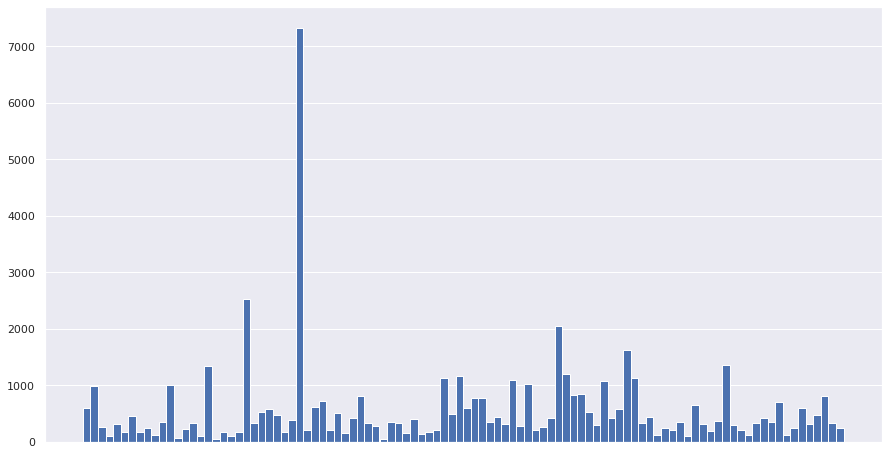

In [93]:
plt.figure(figsize=(15,8))
df['county_city_location'].sort_values().hist(bins=100)
plt.xticks([])
plt.show()

Распределение неравномерно.

Посмотрим долю виновных по коду города.

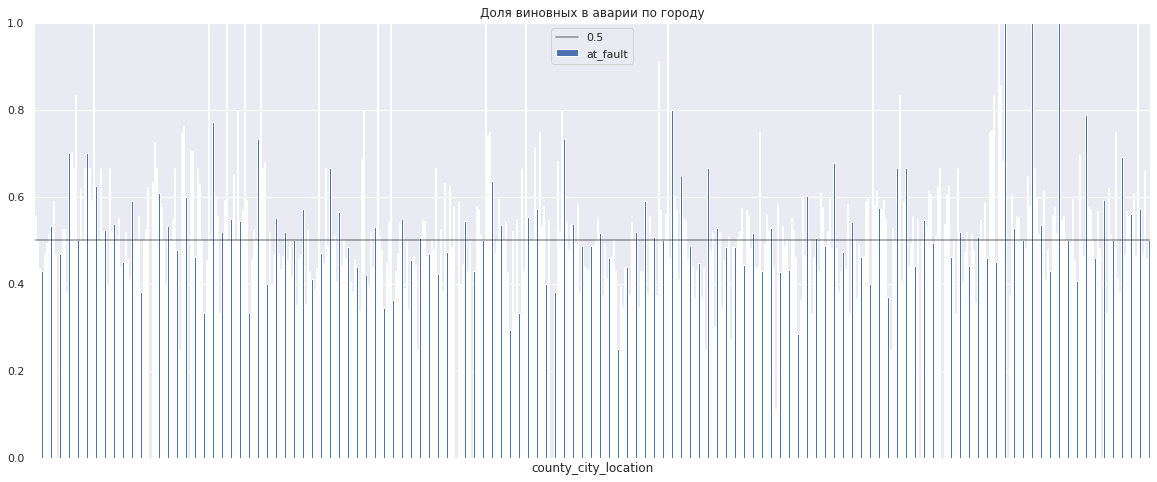

In [94]:
plt.figure(figsize=(20,8))
df.groupby('county_city_location')['at_fault'].mean().sort_index().plot(kind='bar')
plt.title('Доля виновных в аварии по городу')
plt.axhline(y=0.5,c='black',alpha=0.4,label='0.5')
plt.legend()
plt.ylim(0,1)
plt.xticks([])
plt.show()

Видим, что в некоторых городах доля виновных составляет 100%. Вряд ли это соответствует правде. Модель может обучиться неправильно. Поэтому эту фичу лучше не использовать.

С другой стороны это может отражать правду, и, действительно, в некоторых регионах все аварии исключительно по вине автомобиля, но это вызывает много вопросов и требует дополнительных исследований.

In [95]:
cols_to_drop = ['county_city_location']

**'county_location'**

In [96]:
df['county_location'].dtype

dtype('O')

In [97]:
df['county_location'].isna().sum()

0

In [98]:
df['county_location'].nunique()

58

In [99]:
df['county_location'].unique()

array(['san diego', 'sacramento', 'san bernardino', 'santa clara',
       'los angeles', 'kern', 'riverside', 'san benito',
       'san luis obispo', 'humboldt', 'el dorado', 'san joaquin',
       'placer', 'plumas', 'butte', 'nevada', 'mariposa', 'orange',
       'imperial', 'kings', 'yolo', 'tulare', 'sonoma', 'santa barbara',
       'fresno', 'stanislaus', 'ventura', 'shasta', 'santa cruz',
       'mendocino', 'madera', 'lassen', 'alameda', 'monterey', 'merced',
       'yuba', 'contra costa', 'san mateo', 'solano', 'tehama',
       'san francisco', 'modoc', 'calaveras', 'amador', 'mono', 'marin',
       'tuolumne', 'sutter', 'napa', 'colusa', 'siskiyou', 'glenn',
       'inyo', 'lake', 'trinity', 'alpine', 'del norte', 'sierra'],
      dtype=object)

In [100]:
df['county_location'].value_counts()

los angeles        16069
orange              5349
san diego           3726
san bernardino      3639
riverside           3310
sacramento          2176
alameda             1872
santa clara         1838
ventura             1464
kern                1411
fresno              1073
contra costa         987
san mateo            936
san joaquin          934
stanislaus           802
santa barbara        731
tulare               720
sonoma               690
placer               589
monterey             576
solano               550
san francisco        507
san luis obispo      440
santa cruz           430
merced               395
marin                372
humboldt             330
madera               326
butte                320
el dorado            290
shasta               283
yolo                 281
kings                247
imperial             209
napa                 209
mendocino            194
nevada               184
tehama               149
sutter               144
tuolumne             123


In [101]:
df['county_location'].value_counts(normalize=True)

los angeles       0.287
orange            0.096
san diego         0.067
san bernardino    0.065
riverside         0.059
sacramento        0.039
alameda           0.033
santa clara       0.033
ventura           0.026
kern              0.025
fresno            0.019
contra costa      0.018
san mateo         0.017
san joaquin       0.017
stanislaus        0.014
santa barbara     0.013
tulare            0.013
sonoma            0.012
placer            0.011
monterey          0.010
solano            0.010
san francisco     0.009
san luis obispo   0.008
santa cruz        0.008
merced            0.007
marin             0.007
humboldt          0.006
madera            0.006
butte             0.006
el dorado         0.005
shasta            0.005
yolo              0.005
kings             0.004
imperial          0.004
napa              0.004
mendocino         0.003
nevada            0.003
tehama            0.003
sutter            0.003
tuolumne          0.002
lake              0.002
calaveras       

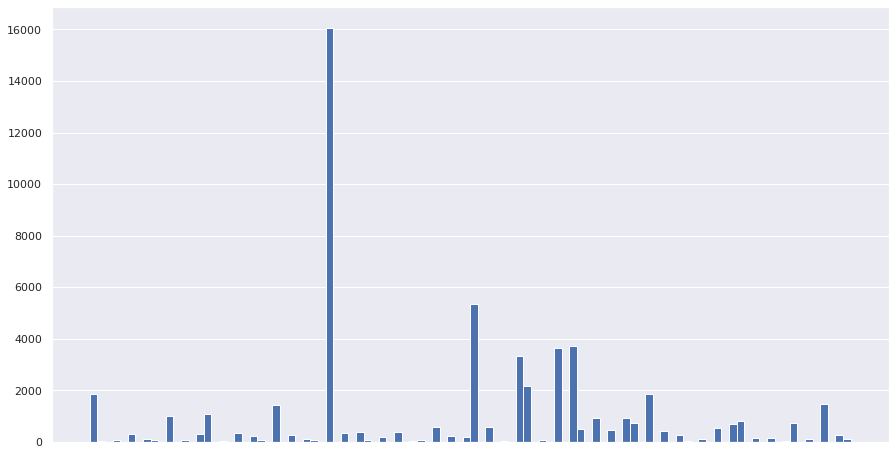

In [102]:
plt.figure(figsize=(15,8))
df['county_location'].sort_values().hist(bins=100)
plt.xticks([])
plt.show()

Построим график доли `at_fault = 1` по `county_location`, чтобы выяснить сбалансированность классов по региону.

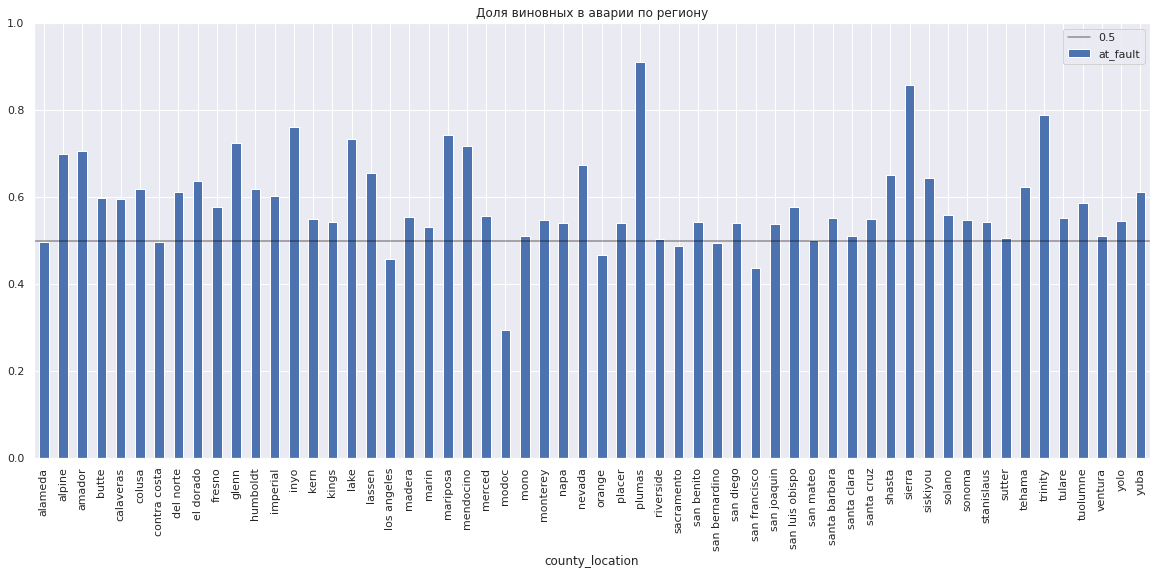

In [103]:
plt.figure(figsize=(20,8))
df.groupby('county_location')['at_fault'].mean().sort_index().plot(kind='bar')
plt.title('Доля виновных в аварии по региону')
plt.axhline(y=0.5,c='black',alpha=0.4,label='0.5')
plt.legend()
plt.ylim(0,1)
# plt.xticks([])
plt.show()

В целом баланс удовлетворительный.

In [104]:
# cols_to_drop.append('county_location')

In [105]:
# cols_to_drop

**'collision_date'**

In [106]:
df['collision_date'].dtype

dtype('<M8[ns]')

In [107]:
df['collision_date'].describe(datetime_is_numeric=True)

count                            55988
mean     2012-03-23 02:10:11.616774912
min                2012-01-01 00:00:00
25%                2012-02-10 00:00:00
50%                2012-03-19 00:00:00
75%                2012-04-27 00:00:00
max                2012-12-31 00:00:00
Name: collision_date, dtype: object

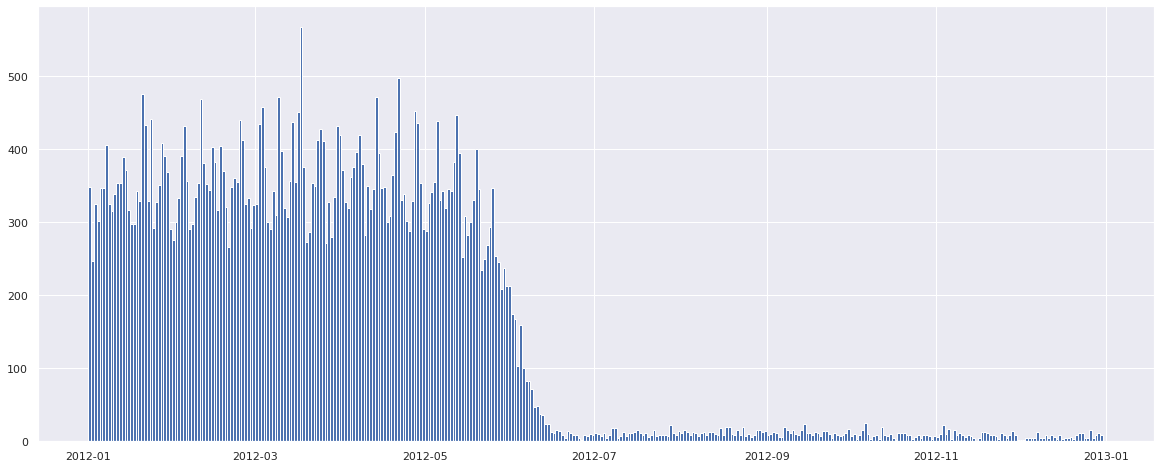

In [108]:
plt.figure(figsize=(20,8))
df['collision_date'].sort_values().hist(bins=365)
plt.show()

Видим, что вторая половиная года недопредставлена.

Проверим баланс классов по каждому дню.

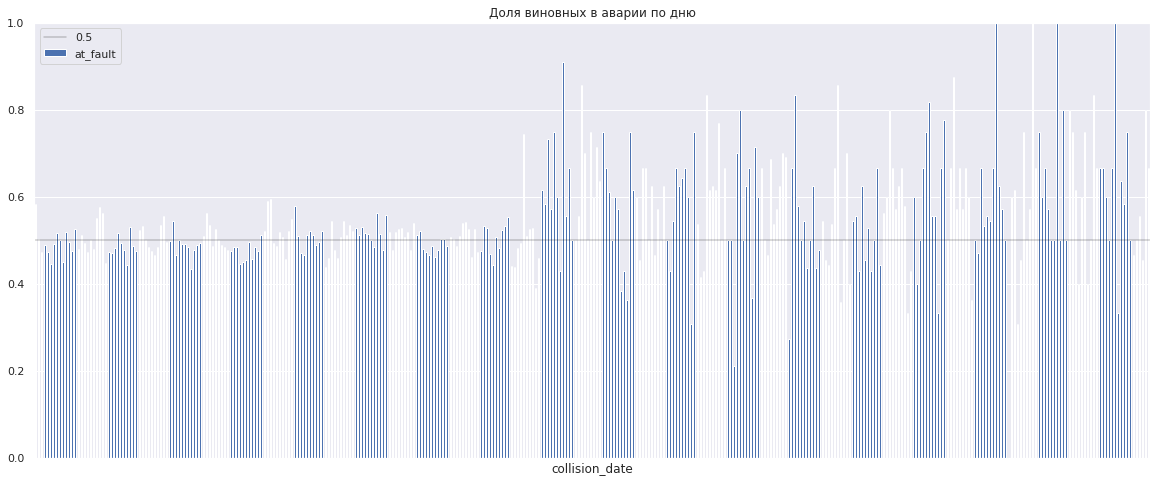

In [109]:
plt.figure(figsize=(20,8))
df.groupby('collision_date')['at_fault'].mean().sort_index().plot(kind='bar')
plt.title('Доля виновных в аварии по дню')
plt.axhline(y=0.5,c='black',alpha=0.2,label='0.5')
plt.legend()
plt.ylim(0,1)
plt.xticks([])
plt.show()

Здесь большой дисбаланс классов во второй половине года. Это нужно как-то уровнять, либо не использовать. Тем не менее вытащим месяц, т.к. он влияет на световой день, а значит на освещенность дороги, на состояние поверхности дороги и другие сезонные признаки.

In [110]:
df['month'] = df['collision_date'].dt.month

In [111]:
df.head(3)

,county_city_location,county_location,collision_date,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age,at_fault,month
0,3712,san diego,2012-03-30,42.000,had not been drinking,None,0.000,sedan,auto,2.000,0,3
1,3404,sacramento,2012-04-02,31.000,had not been drinking,None,0.000,sedan,auto,5.000,0,4
2,3400,sacramento,2012-11-13,21.000,had not been drinking,None,0.000,sedan,auto,1.000,0,11


Дата нам как таковая не нужна, поэтому дропнем.

In [112]:
cols_to_drop.append('collision_date')

In [113]:
cols_to_drop

['county_city_location', 'collision_date']

**'insurance_premium'**

In [114]:
df['insurance_premium'].dtype

dtype('float64')

In [115]:
df['insurance_premium'].isna().sum()

543

In [116]:
df['insurance_premium'].describe()

count   55445.000
mean       37.633
std        16.334
min         0.000
25%        24.000
50%        34.000
75%        49.000
max       105.000
Name: insurance_premium, dtype: float64

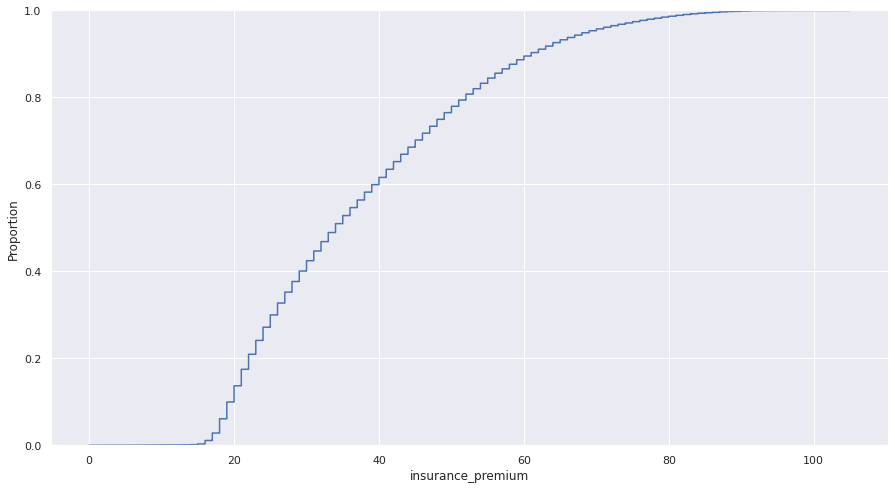

In [117]:
# plt.figure(figsize=(15,8))
# df['insurance_premium'].hist(bins=100)
# plt.show()

plt.figure(figsize=(15,8))
sns.ecdfplot(data=df,x='insurance_premium')
plt.show()

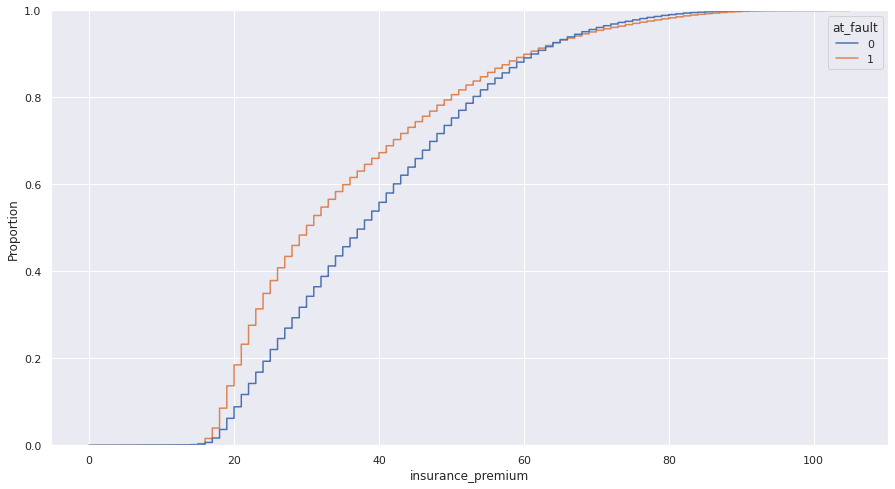

In [118]:
plt.figure(figsize=(15,8))
sns.ecdfplot(data=df,x='insurance_premium',hue='at_fault')
plt.show()

Объем страховки влияет на вероятность быть виновным в аварии? Меньше страховка, больше шансов стать виновником аварии.

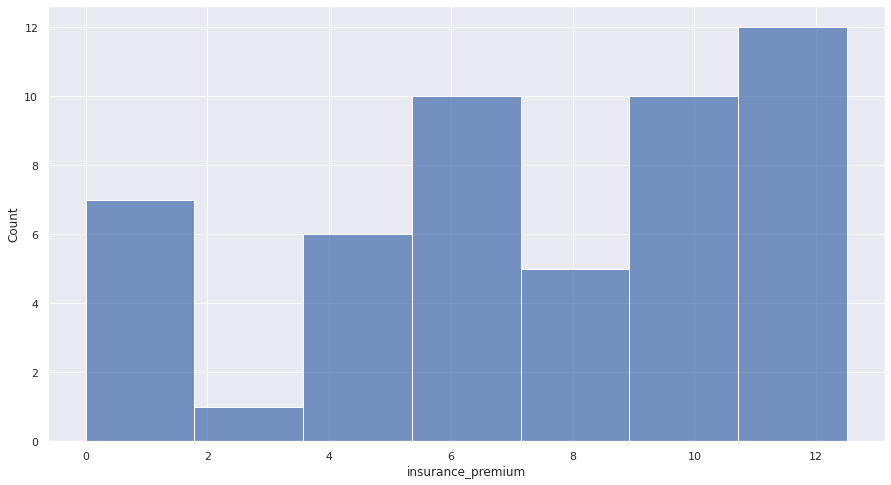

In [119]:
plt.figure(figsize=(15,8))
sns.histplot(data=df,x='insurance_premium',binrange=[0,12.5])
plt.show()

Заполним пропуски `-999`

In [120]:
df['insurance_premium'] = df['insurance_premium'].fillna(-999)

**'party_sobriety'**

In [121]:
df['party_sobriety'].dtype

dtype('O')

In [122]:
df['party_sobriety'].isna().sum()

868

In [123]:
df['party_sobriety'].nunique()

6

In [124]:
df['party_sobriety'].value_counts(dropna=False)

had not been drinking                     48357
had been drinking, under influence         4445
impairment unknown                         1234
NaN                                         868
had been drinking, not under influence      575
had been drinking, impairment unknown       259
not applicable                              250
Name: party_sobriety, dtype: int64

Пропуски заменим на `Not Stated`

In [125]:
df['party_sobriety'] = df['party_sobriety'].fillna('not stated')

/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:3803: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


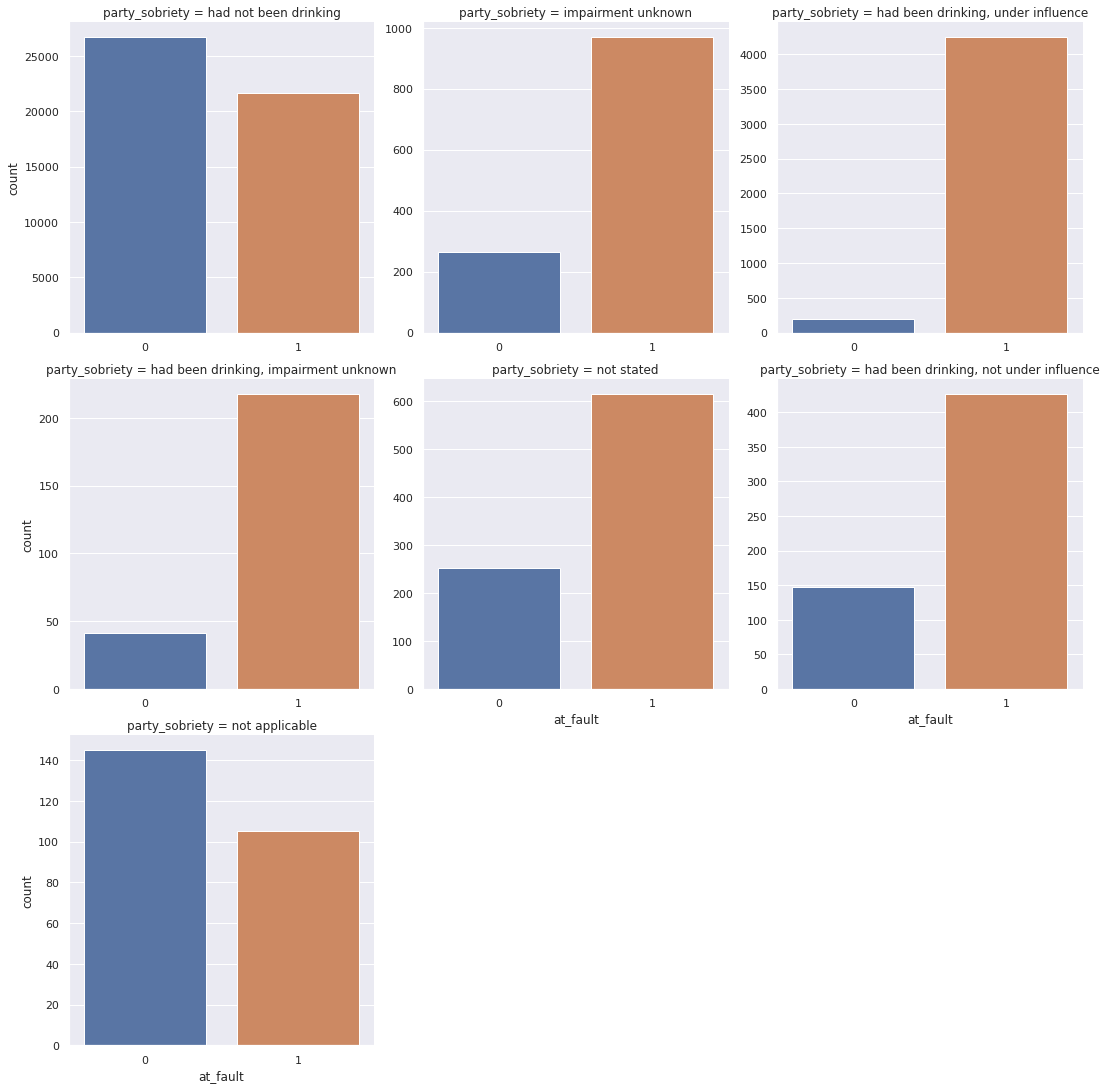

In [126]:
# plt.figure(figsize=(15,8))
sns.catplot(data=df,x='at_fault',kind='count',col='party_sobriety',col_wrap=3,sharex=False,sharey=False)
plt.show()

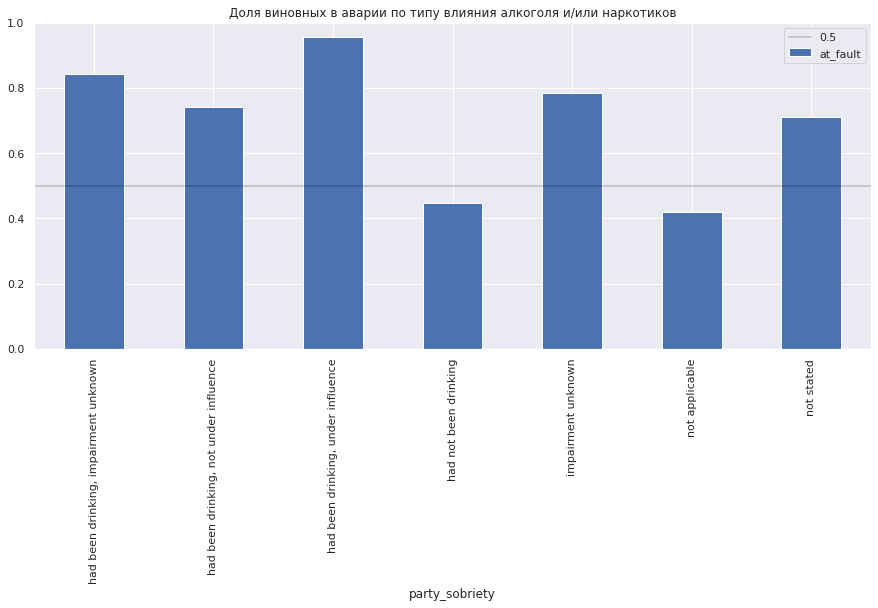

In [127]:
plt.figure(figsize=(15,6))
df.groupby('party_sobriety')['at_fault'].mean().sort_index().plot(kind='bar')
plt.title('Доля виновных в аварии по типу влияния алкоголя и/или наркотиков')
plt.axhline(y=0.5,c='black',alpha=0.2,label='0.5')
plt.legend()
plt.ylim(0,1)
# plt.xticks([])
plt.show()

Вероятность стать виновником аварии повышается при наличии какого-то воздействия.

**'party_drug_physical'**

In [128]:
df['party_drug_physical'].dtype

dtype('O')

In [129]:
df['party_drug_physical'].isna().sum()

53139

In [130]:
df['party_drug_physical'].value_counts(dropna=False)

NaN                      53139
G                         1234
under drug influence       856
sleepy/fatigued            390
not applicable             250
impairment - physical      119
Name: party_drug_physical, dtype: int64

Пропуски заменим на `Not Stated`, а `G` на `Impairment Unknown`

In [131]:
df['party_drug_physical'] = df['party_drug_physical'].fillna('not stated')

In [132]:
df.loc[df['party_drug_physical'] == 'G', 'party_drug_physical'] = 'impairment unknown'

In [133]:
df['party_drug_physical'].value_counts(dropna=False)

not stated               53139
impairment unknown        1234
under drug influence       856
sleepy/fatigued            390
not applicable             250
impairment - physical      119
Name: party_drug_physical, dtype: int64

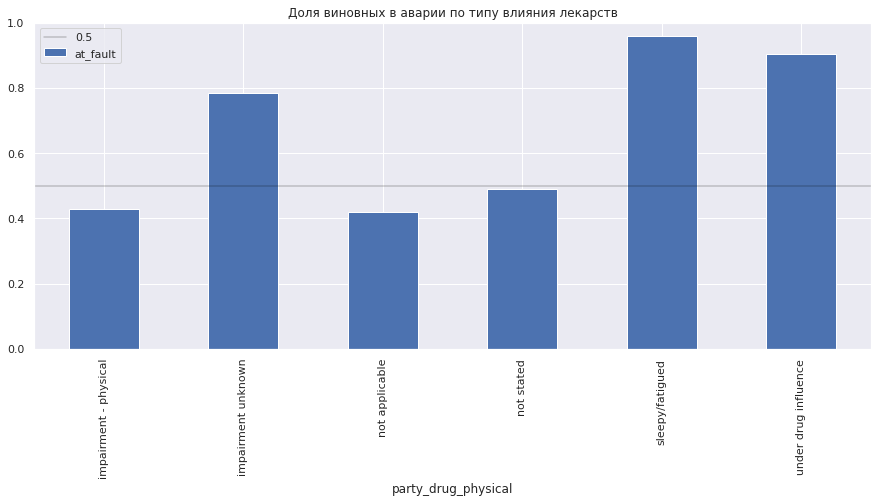

In [134]:
plt.figure(figsize=(15,6))
df.groupby('party_drug_physical')['at_fault'].mean().sort_index().plot(kind='bar')
plt.title('Доля виновных в аварии по типу влияния лекарств')
plt.axhline(y=0.5,c='black',alpha=0.2,label='0.5')
plt.legend()
plt.ylim(0,1)
# plt.xticks([])
plt.show()

Похожая картина. Влияние лекарств повышает вероятность стать виновником аварии.

**'cellphone_in_use'**

In [135]:
df['cellphone_in_use'].dtype

dtype('float64')

In [136]:
df['cellphone_in_use'].isna().sum()

4455

In [137]:
df['cellphone_in_use'].value_counts(dropna=False)

0.000    50480
NaN       4455
1.000     1053
Name: cellphone_in_use, dtype: int64

In [138]:
df['cellphone_in_use'] = df['cellphone_in_use'].fillna(-999)

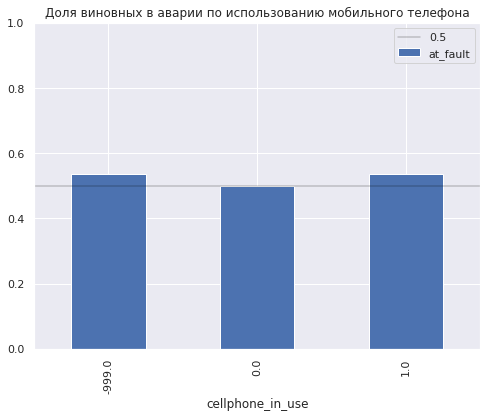

In [139]:
plt.figure(figsize=(8,6))
df.groupby('cellphone_in_use')['at_fault'].mean().sort_index().plot(kind='bar')
plt.title('Доля виновных в аварии по использованию мобильного телефона')
plt.axhline(y=0.5,c='black',alpha=0.2,label='0.5')
plt.legend()
plt.ylim(0,1)
# plt.xticks([])
plt.show()

Влияние само по себе несущественно. А пропуски похожи на 1.

2 категории. Можно применить OHE без drop_first.

**'vehicle_type'**

In [140]:
df['vehicle_type'].dtype

dtype('O')

In [141]:
df['vehicle_type'].value_counts(dropna=False)

sedan    37030
coupe    18954
other        4
Name: vehicle_type, dtype: int64

Представлено всего 3 класса из 5. Все кроме `sedan` и `coupe` нужно будет отправлять в `other`.

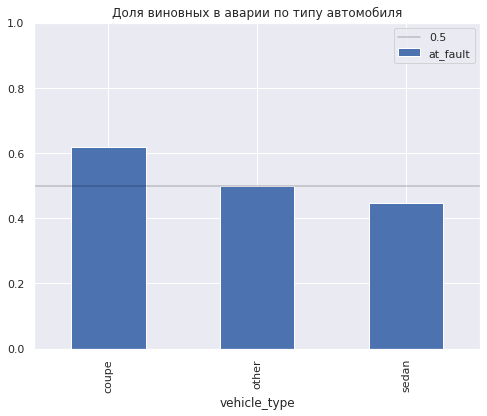

In [142]:
plt.figure(figsize=(8,6))
df.groupby('vehicle_type')['at_fault'].mean().sort_index().plot(kind='bar')
plt.title('Доля виновных в аварии по типу автомобиля')
plt.axhline(y=0.5,c='black',alpha=0.2,label='0.5')
plt.legend()
plt.ylim(0,1)
# plt.xticks([])
plt.show()

Влияние несущественно.

**'vehicle_transmission'**

In [143]:
df['vehicle_transmission'].dtype

dtype('O')

In [144]:
df['vehicle_transmission'].value_counts(dropna=False)

manual    29173
auto      25956
NaN         859
Name: vehicle_transmission, dtype: int64

In [145]:
df['vehicle_transmission'] = df['vehicle_transmission'].fillna('unknown')

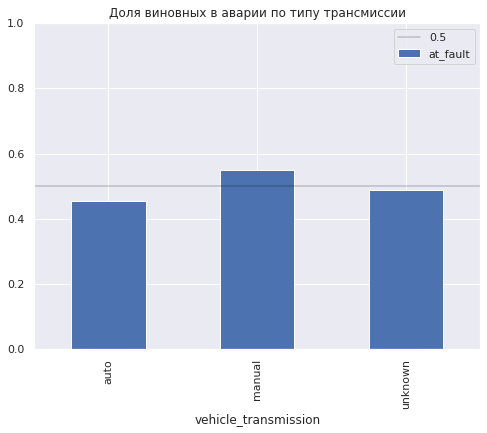

In [146]:
plt.figure(figsize=(8,6))
df.groupby('vehicle_transmission')['at_fault'].mean().sort_index().plot(kind='bar')
plt.title('Доля виновных в аварии по типу трансмиссии')
plt.axhline(y=0.5,c='black',alpha=0.2,label='0.5')
plt.legend()
plt.ylim(0,1)
# plt.xticks([])
plt.show()

Влияние несущественно.

**vehicle_age**

In [147]:
df['vehicle_age'].dtype

dtype('float64')

In [148]:
df['vehicle_age'].value_counts(dropna=False,normalize=False)

3.000      10917
4.000       7122
2.000       6022
5.000       5536
6.000       3927
7.000       3826
8.000       3498
0.000       3077
9.000       2762
1.000       2540
10.000      1937
NaN         1692
11.000      1377
12.000       877
13.000       550
14.000       280
15.000        36
16.000         6
17.000         3
161.000        2
19.000         1
Name: vehicle_age, dtype: int64

Удалим значение 161. Оно определенно аномально.

In [149]:
# df[df['vehicle_age'] != 161]

In [150]:
df = df[df['vehicle_age'] != 161]

Заполним пропуски -999.

In [151]:
df['vehicle_age'] = df['vehicle_age'].fillna(-999)

Автомобили старше 15 лет включительно определим в категорию 14 лет. Потому что их мало.

In [152]:
df.loc[df['vehicle_age'] > 14,'vehicle_age'] = 14

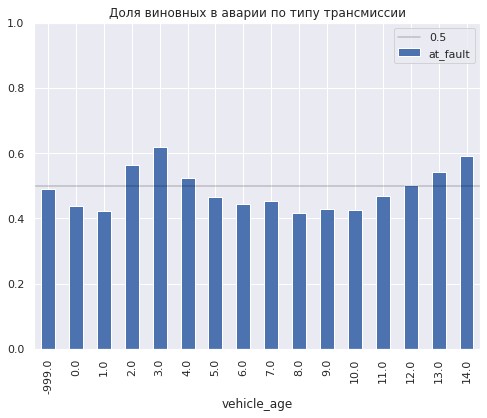

In [153]:
plt.figure(figsize=(8,6))
df.groupby('vehicle_age')['at_fault'].mean().sort_index().plot(kind='bar')
plt.title('Доля виновных в аварии по типу трансмиссии')
plt.axhline(y=0.5,c='black',alpha=0.2,label='0.5')
plt.legend()
plt.ylim(0,1)
# plt.xticks([])
plt.show()

**'at_fault'**

In [154]:
df['at_fault'].value_counts()

1    28238
0    27748
Name: at_fault, dtype: int64

In [155]:
df['at_fault'].value_counts(normalize=True)

1   0.504
0   0.496
Name: at_fault, dtype: float64

Сбалансированно!

**Отберем только используемые фичи**

In [156]:
df = df.drop(columns=cols_to_drop)

In [157]:
df.head()

,county_location,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age,at_fault,month
0,san diego,42.000,had not been drinking,not stated,0.000,sedan,auto,2.000,0,3
1,sacramento,31.000,had not been drinking,not stated,0.000,sedan,auto,5.000,0,4
2,sacramento,21.000,had not been drinking,not stated,0.000,sedan,auto,1.000,0,11
3,san bernardino,31.000,had not been drinking,not stated,0.000,sedan,auto,4.000,0,9
4,sacramento,41.000,had not been drinking,not stated,0.000,coupe,auto,6.000,0,11


In [158]:
df.duplicated().sum()

10679

In [159]:
df = df.drop_duplicates()

In [160]:
df['at_fault'].value_counts()

1    23286
0    22021
Name: at_fault, dtype: int64

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45307 entries, 0 to 56247
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   county_location       45307 non-null  object 
 1   insurance_premium     45307 non-null  float64
 2   party_sobriety        45307 non-null  object 
 3   party_drug_physical   45307 non-null  object 
 4   cellphone_in_use      45307 non-null  float64
 5   vehicle_type          45307 non-null  object 
 6   vehicle_transmission  45307 non-null  object 
 7   vehicle_age           45307 non-null  float64
 8   at_fault              45307 non-null  int64  
 9   month                 45307 non-null  int64  
dtypes: float64(3), int64(2), object(5)
memory usage: 3.8+ MB


In [162]:
df.isna().sum()

county_location         0
insurance_premium       0
party_sobriety          0
party_drug_physical     0
cellphone_in_use        0
vehicle_type            0
vehicle_transmission    0
vehicle_age             0
at_fault                0
month                   0
dtype: int64

In [163]:
X = df.drop(columns='at_fault')
y = df['at_fault']

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.1,stratify=y)

**Преобразование фичей**

Нужно подготовить разные OHE для категорий.

In [165]:
X_train.columns

Index(['county_location', 'insurance_premium', 'party_sobriety',
       'party_drug_physical', 'cellphone_in_use', 'vehicle_type',
       'vehicle_transmission', 'vehicle_age', 'month'],
      dtype='object')

In [166]:
cat_cols_ordinary_ohe = X_train[['county_location','party_sobriety','party_drug_physical']].columns
ordinary_ohe = OneHotEncoder(handle_unknown='ignore')

In [167]:
# pd.DataFrame(ordinary_ohe.fit_transform(X_train[cat_cols_ordinary_ohe]).todense(),columns=ordinary_ohe.get_feature_names_out())

Сделаем так, чтобы категория `unknown` была при `0,0` в `cellphone_in_use`.

In [168]:
cellphone_in_use = X_train[['cellphone_in_use']].columns
# cellphone_in_use = 'cellphone_in_use'
cellphone_ohe = OneHotEncoder(categories=[[0.,1.]],handle_unknown='ignore')

In [169]:
# pd.DataFrame(cellphone_ohe.fit_transform(X_train[['cellphone_in_use']]).todense(),columns=cellphone_ohe.get_feature_names_out())

Повторим для `vehicle_type`.

In [170]:
vehicle_type = X_train[['vehicle_type']].columns
vehicle_type_ohe = OneHotEncoder(categories=[['sedan','coupe']],handle_unknown='ignore')

In [171]:
vehicle_transmission = X_train[['vehicle_transmission']].columns
vehicle_transmission_ohe = OneHotEncoder(categories=[['auto','manual']],handle_unknown='ignore')

Применим син-кос преобразование для месяца.

In [172]:
for data in [X_train,X_test]:
    data['month_sin'] = np.sin((data['month']-1)*(2.*np.pi/12))
    data['month_cos'] = np.cos((data['month']-1)*(2.*np.pi/12))

/tmp/ipykernel_48/3185474918.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['month_sin'] = np.sin((data['month']-1)*(2.*np.pi/12))
/tmp/ipykernel_48/3185474918.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['month_cos'] = np.cos((data['month']-1)*(2.*np.pi/12))


In [173]:
X_train = X_train.drop(columns='month')
X_test = X_test.drop(columns='month')

In [174]:
X_train['month_cos'].describe()

count   40776.000
mean        0.326
std         0.596
min        -1.000
25%         0.000
50%         0.500
75%         0.866
max         1.000
Name: month_cos, dtype: float64

In [175]:
logreg_columntransformer = ColumnTransformer([
                                                ('ordinary_ohe',ordinary_ohe,cat_cols_ordinary_ohe),
                                              ('cellphone_ohe',cellphone_ohe,cellphone_in_use),
                                              ('vehicle_type_ohe',vehicle_type_ohe,vehicle_type),
                                              ('vehicle_transmission_ohe',vehicle_transmission_ohe,vehicle_transmission),
                                              ('scaler',StandardScaler(),['vehicle_age','insurance_premium'])
                                                ],
                                              remainder='passthrough',
                                                # sparse_threshold=0
                                            )



forest_columntransformer = ColumnTransformer([('ordinary_ohe',ordinary_ohe,cat_cols_ordinary_ohe),
                                              ('cellphone_ohe',cellphone_ohe,cellphone_in_use),
                                              ('vehicle_type_ohe',vehicle_type_ohe,vehicle_type),
                                              ('vehicle_transmission_ohe',vehicle_transmission_ohe,vehicle_transmission)],
                                              remainder='passthrough')

## Сравнение моделей

1. Логистическая регрессия
2. Случайный лес
3. catboost
4. lgbm

Проведем кросс валидацию этих моделей. И сравнивать будем по `ROC AUC`.

In [176]:
X_train_sampled = X_train.sample(5000)
y_train_sampled = y_train[X_train_sampled.index]

In [177]:
%%time
param_grid = [    
    {
    'logreg__C' : np.logspace(-4, 4, 5),
    'logreg__max_iter' : [100,300, 500]
    }
]

logreg = Pipeline([('column_transformer',logreg_columntransformer),('logreg',LogisticRegression(max_iter=300))])

# logreg_cv = cross_val_score(logreg,X_train,y_train,cv=10,scoring='roc_auc')
# logreg_cv

logreg_gs = GridSearchCV(logreg,param_grid,n_jobs=-1,cv=10)

logreg_gs.fit(X_train_sampled,y_train_sampled)

display(logreg_gs.best_params_,logreg_gs.best_score_)

logreg_gs_cv_results = pd.DataFrame(logreg_gs.cv_results_)
logreg_gs_cv_results = logreg_gs_cv_results.loc[logreg_gs_cv_results['params'] == logreg_gs.best_params_]

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

{'logreg__C': 0.01, 'logreg__max_iter': 100}

0.623

CPU times: user 17.3 s, sys: 51.6 ms, total: 17.3 s
Wall time: 17.7 s


In [178]:
%%time
param_grid = [    
    {'forest__n_estimators': [10,100,300,500],
    'forest__max_depth' : [2,4,7,10],
    'forest__max_features' : [1,3,6,10]
    }
]

forest = Pipeline([('column_transformer',forest_columntransformer),('forest',RandomForestClassifier())])

# forest_cv = cross_val_score(forest,X_train,y_train,cv=10,scoring='roc_auc')
# forest_cv

forest_gs = GridSearchCV(forest,param_grid,n_jobs=-1,cv=10)

forest_gs.fit(X_train_sampled,y_train_sampled)

display(forest_gs.best_params_,forest_gs.best_score_)

forest_gs_cv_results = pd.DataFrame(forest_gs.cv_results_)
forest_gs_cv_results = forest_gs_cv_results.loc[forest_gs_cv_results['params'] == forest_gs.best_params_]

{'forest__max_depth': 10,
 'forest__max_features': 10,
 'forest__n_estimators': 100}

0.6405999999999998

CPU times: user 6min 13s, sys: 1.74 s, total: 6min 15s
Wall time: 6min 15s


In [179]:
cat_features = ['county_location', 'party_sobriety',
               'party_drug_physical', 'cellphone_in_use', 'vehicle_type',
               'vehicle_transmission']

X_train_for_cb = X_train_sampled.copy()

X_train_for_cb[cat_features] = X_train_for_cb[cat_features].astype('str')

cb_dataset = cb.Pool(X_train_for_cb,y_train_sampled,cat_features=cat_features)

model = cb.CatBoostClassifier(loss_function='Logloss',custom_loss= 'AUC',verbose=0)

grid = {'learning_rate': [0.001,0.01,0.1],
        'depth': [2,4,6]}

cb_grid_search = model.grid_search(grid,cb_dataset,cv=10,verbose=False,plot=True)

def print_cv_summary(cv_data):
    cv_data.head(10)

    best_value = cv_data['test-AUC-mean'].max()
    best_iter = cv_data['test-AUC-mean'].values.argmax()

    print('Best validation AUC score : {:.4f}±{:.4f} on step {}'.format(
        best_value,
        cv_data['test-AUC-std'][best_iter],
        best_iter)
    )
    
display(cb_grid_search['params'])
cb_grid_search_cv_results = pd.DataFrame(cb_grid_search['cv_results'])
print_cv_summary(cb_grid_search_cv_results)
        

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.6369793088
bestIteration = 999

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.6153794322
bestIteration = 997

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.6150552919
bestIteration = 174

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.6306928981
bestIteration = 999

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.615507496
bestIteration = 977

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.614101076
bestIteration = 110

Metric AUC is not calculated on train by default. To cal

{'depth': 4, 'learning_rate': 0.1}

Best validation AUC score : 0.6997±0.0296 on step 85


In [180]:
# cat_features = ['county_location', 'party_sobriety',
#                'party_drug_physical', 'cellphone_in_use', 'vehicle_type',
#                'vehicle_transmission']

# X_train_for_cb = X_train_sampled.copy()

# X_train_for_cb[cat_features] = X_train_for_cb[cat_features].astype('str')

# cb_dataset = cb.Pool(X_train_for_cb,y_train_sampled,cat_features=cat_features)

# params = {'loss_function': 'Logloss',
#           'iterations': 10000,
#           'custom_loss': 'AUC',
#           'learning_rate': 0.01,
#           'verbose': 0,
#           'use_best_model': True,
#           'eval_metric': 'AUC',
#           'od_type': 'IncToDec',
#           'od_pval': 1e-03
#          }

# def print_cv_summary(cv_data):
#     cv_data.head(10)

#     best_value = cv_data['test-AUC-mean'].max()
#     best_iter = cv_data['test-AUC-mean'].values.argmax()

#     print('Best validation AUC score : {:.4f}±{:.4f} on step {}'.format(
#         best_value,
#         cv_data['test-AUC-std'][best_iter],
#         best_iter)
#     )
    
# cv_data = cb.cv(
#     params = params,
#     pool = cb_dataset,
#     fold_count=10,
#     shuffle=True,
#     partition_random_seed=0,
#     plot=True,
#     stratified=True,
#     # verbose=False
# )

# print_cv_summary(cv_data)

In [182]:
X_train_for_lgb = X_train_sampled.copy()

X_train_for_lgb[cat_features] = X_train_for_lgb[cat_features].astype('category')

# dataset_lgb = lgb.Dataset(X_train_for_lgb, label=y_train_sampled,categorical_feature=cat_features)

# param = {
#          'num_leaves': [2,20,50,100],
#          'min_data_in_leaf': [20,100,1000,5000,10000],
#          'max_depth': [2,4,6]
#         }
param = {
         'num_leaves': [20],
         'min_data_in_leaf': [100],
         'max_depth': [2]
        }

# lgb_cv = lgb.cv(param, dataset_lgb, nfold=10)
# lgb_cv = pd.DataFrame(lgb_cv)

lgb_estimator = lgb.LGBMClassifier(objective='binary',metric='auc',verbosity=-1)

lgb_gs = GridSearchCV(lgb_estimator,param_grid = param,cv=10)
lgb_gs.fit(X_train_for_lgb,y_train_sampled,categorical_feature=cat_features)

display(lgb_gs.best_params_,lgb_gs.best_score_)

lgb_gs_cv_results = pd.DataFrame(lgb_gs.cv_results_)
lgb_gs_cv_results = lgb_gs_cv_results.loc[lgb_gs_cv_results['params'] == lgb_gs.best_params_]

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


{'max_depth': 2, 'min_data_in_leaf': 100, 'num_leaves': 20}

0.6315999999999999

In [183]:
display(lgb_gs.best_params_,lgb_gs.best_score_)

{'max_depth': 2, 'min_data_in_leaf': 100, 'num_leaves': 20}

0.6315999999999999

Лучшие гиперпараметры подобранные заранее.  
`{'max_depth': 2, 'min_data_in_leaf': 1000, 'num_leaves': 20}`

In [184]:
lgb_gs_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_data_in_leaf,param_num_leaves,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,68.867,52.987,0.134,0.066,2,100,20,"{'max_depth': 2, 'min_data_in_leaf': 100, 'num...",0.610,0.654,...,0.642,0.606,0.636,0.638,0.660,0.618,0.624,0.632,0.017,1


In [185]:
cv_data_mean = cb_grid_search_cv_results.loc[cb_grid_search_cv_results['test-AUC-mean'].argmax(),'test-AUC-mean']
cv_data_std = cb_grid_search_cv_results.loc[cb_grid_search_cv_results['test-AUC-mean'].argmax(),'test-AUC-std']
cv_data_mean,cv_data_std

(0.6997166342962062, 0.02960740970889562)

In [187]:
comp =  {'logreg':[*logreg_gs_cv_results['mean_test_score'].values,*logreg_gs_cv_results['std_test_score'].values],
        'forest':[*forest_gs_cv_results['mean_test_score'].values,*forest_gs_cv_results['std_test_score'].values],
        'catboost': [cv_data_mean,cv_data_std],
        'lgbm': [*lgb_gs_cv_results['mean_test_score'].values,*lgb_gs_cv_results['std_test_score'].values]}
comp = pd.DataFrame(comp,index=['mean','std']).T
comp

,mean,std
logreg,0.623,0.013
forest,0.641,0.014
catboost,0.700,0.030
lgbm,0.632,0.017


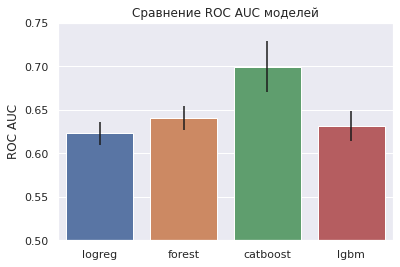

In [188]:
g = sns.barplot(y=comp['mean'],x=comp.index,yerr=comp['std'])
# g.errorbar(x=comp.index, y=comp['mean'], yerr=comp['std'], ls='', lw=2, color='black')
plt.ylim(0.5,0.75)
plt.title('Сравнение ROC AUC моделей')
plt.ylabel('ROC AUC')
plt.show()

Предпочтем `lgbm` катбусту. 

## Исследование модели LGBM

Обучим модель на всех тренировочных данных и изучим ее показатели на тесте.

In [189]:
X_train_for_lgb = X_train.copy()

X_train_for_lgb[cat_features] = X_train_for_lgb[cat_features].astype('category')

# dataset_lgb = lgb.Dataset(X_train_for_lgb, label=y_train_sampled,categorical_feature=cat_features)

lgb_estimator = lgb.LGBMClassifier(objective='binary',metric='auc',max_depth= 2, min_data_in_leaf= 1000, num_leaves= 20)
lgb_estimator.fit(X_train_for_lgb,y_train,categorical_feature=cat_features)

col_categories_codes = {}
for col in cat_features:
    col_categories_codes[col]=X_train_for_lgb[col].cat.categories

X_test_for_lgb = X_test.copy()
for col in cat_features:
    X_test_for_lgb[col] = pd.Categorical(X_test_for_lgb[col],categories=col_categories_codes[col])

pred = lgb_estimator.predict(X_test_for_lgb)
# print(confusion_matrix(y_test.values,pred))
# ConfusionMatrixDisplay.from_predictions(y_test,pred)
print(pd.DataFrame(confusion_matrix(y_test.values,pred)))
print(classification_report(y_test.values,pred))
print('ROC AUC score:',roc_auc_score(y_test,pred))

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


      0     1
0  1651   551
1  1021  1308
              precision    recall  f1-score   support

           0       0.62      0.75      0.68      2202
           1       0.70      0.56      0.62      2329

    accuracy                           0.65      4531
   macro avg       0.66      0.66      0.65      4531
weighted avg       0.66      0.65      0.65      4531

ROC AUC score: 0.6556936802446272


Из всех ошибок модель в 2 раза больше предсказала ложно положительный результат - это ведет к упущенной выгоде и необоснованным отказам.
С другой стороны ложно отрицательных в 2 раза меньше, чем ложно положительных - это риски предоставления доступа водителю, который вероятно станет виновником аварии, если попадет.

По этой же логике можно определить важность метрик `precision` и `recall`, выяснив у заказчика, что важнее не отказать не рисковым или найти всех рисковых.

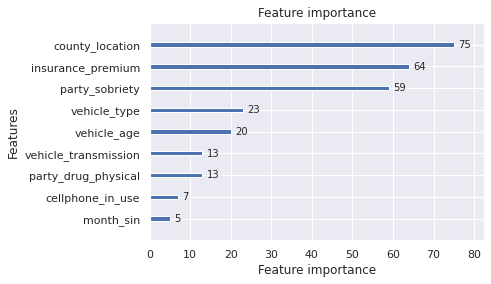

In [190]:
lgb.plot_importance(lgb_estimator,importance_type='split');

Я бы предположил, что большое кол-во сплитов в `count_location` говорит содержании множества факторов "внутри" округа, влияющих на вероятность быть виновным в аварии. Качество дорог, культура вождения и подобные специфичные локации признаки.

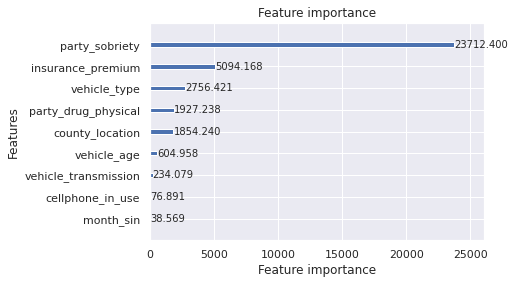

In [191]:
lgb.plot_importance(lgb_estimator,importance_type='gain');

Тревость участников сильнее всего повышает вероятность стать виновником аварии, чем другие признаки.

Ранее уже проводили анализ этих фичей.

## Выводы

Задача: оценка риска попадания в ДТП с любым повреждением транспортного средства сильнее царапины.
> Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

1. У нас есть только записи об авариях, но нет записей о "не авариях" поэтому мы не можем оценить вероятность попадания в ДТП. Все что мы можем, это оценить вероятность виновности водителя уже попавшего в ДТП.
2. Оценка вероятности попадания в ДТП по маршруту подразумевает, что у нас есть маршрут. Маршрут, насколько мне известно, подается как серия данных с точками маршрута и характеристиками  отрезков. Мы не можем описать маршрут 1 числом, типа дистанции до главной дороги. Поэтому предоставленные данные скорее можно использовать для оценки вероятности водителю быть виновником аварии при условии, что авария произошла. Но для этого нужны координаты или какие-то идентификаторы каждой точки, чего в предоставленных данных нет. Поэтому и эта задача кажется невыполнимой.
3. Выбор признаков для обучения модели опирался на предположение, что некоторые фичи мы знаем заранее - это характеристики состояния водителя, характеристики автомобиля и округ. В округе, предположительно, содержится инфа о состоянии дороги, культуры вождения и подобных внешних признаках, которые описывают хотя бы часть маршрута.

Как видим, результативность модели неудовлетворительна. По предоставленным данным скорее нельзя построить эффективную систему предсказания. И сомнительна роль машинного обучения, т.к. достаточно провести ручной анализ признаков и сделать выводы. МЛ при таких данных не нужен.